# Breast Cancer Wisconsin (Diagnostic) — ML Project

**Corso:** Machine Learning — Universita' degli Studi di Milano-Bicocca  
**Dataset:** Breast Cancer Wisconsin (Diagnostic) — UCI ML Repository (ID=17)  
**Modelli:** SVM (Soft Margin, Kernel RBF) + Decision Tree (CART) + K-Means  
**Autori:** [Nomi]  
**Data:** [Data]

## 1. Setup

In [1]:
!pip install pandas numpy matplotlib seaborn scikit-learn ucimlrepo

In [2]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

from ucimlrepo import fetch_ucirepo

from sklearn.model_selection import (
    train_test_split, StratifiedKFold, cross_validate, GridSearchCV
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    ConfusionMatrixDisplay, roc_curve
)

import matplotlib.pyplot as plt
import seaborn as sns

RANDOM_STATE = 42

sns.set_style('whitegrid')
plt.rcParams.update({
    'figure.figsize': (12, 6),
    'figure.dpi': 150,
    'font.size': 11,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
})

---
## 2. Caricamento dataset

In [3]:
dataset = fetch_ucirepo(id=17)
X = dataset.data.features
y_raw = dataset.data.targets

le = LabelEncoder()
y = le.fit_transform(y_raw.iloc[:, 0])  # B=0, M=1

df = X.copy()
df['Diagnosis'] = y_raw.iloc[:, 0]
df['Diagnosis_num'] = y

print(f'Campioni: {X.shape[0]}')
print(f'Feature:  {X.shape[1]}')
print(f'Target:   {le.classes_} -> {le.transform(le.classes_)}')

Campioni: 569
Feature:  30
Target:   ['B' 'M'] -> [0 1]


---
## 3. Exploratory Data Analysis (EDA)

### 3.1 Qualita' dei Dati

In [4]:
missing = X.isnull().sum()
print(f'Missing values totali: {missing.sum()}')

print(f'Righe duplicate: {X.duplicated().sum()}')

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(include=[object]).columns.tolist()
print(f'Feature numeriche: {len(num_cols)}')
print(f'Feature categoriche: {len(cat_cols)}')

Missing values totali: 0
Righe duplicate: 0
Feature numeriche: 30
Feature categoriche: 0


### 3.2 Distribuzione del Target

Distribuzione target:
  B: 357 (62.7%)
  M: 212 (37.3%)

Rapporto minoranza/maggioranza: 0.594
Imbalance moderato -> class_weight="balanced"


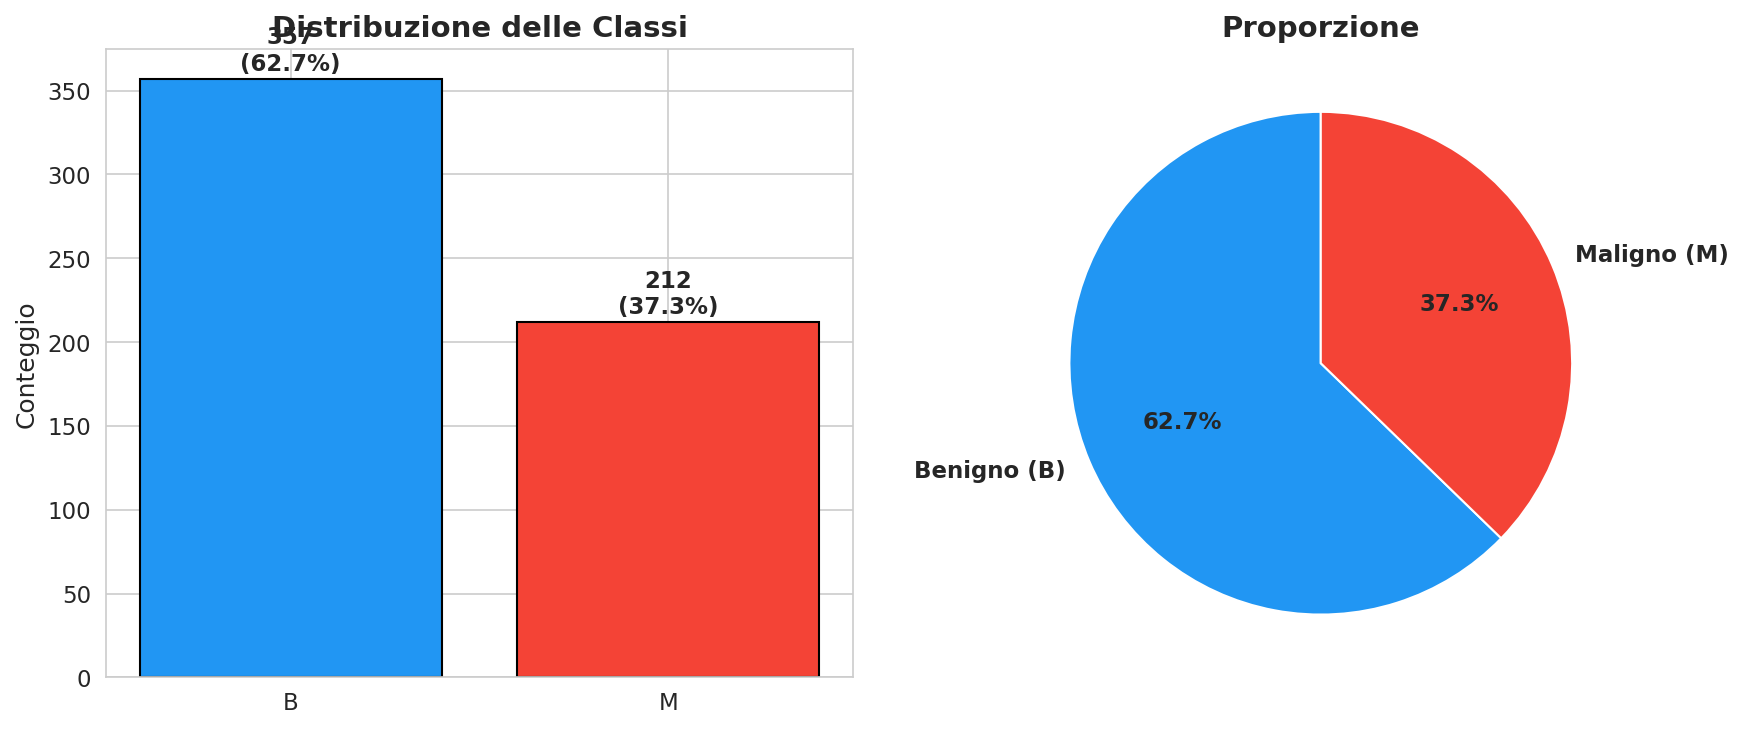

In [5]:
target_counts = df['Diagnosis'].value_counts()
print('Distribuzione target:')
for cls, count in target_counts.items():
    print(f'  {cls}: {count} ({count / len(df) * 100:.1f}%)')

# TODO Decidere se mettere questo
ratio = target_counts.min() / target_counts.max()
print(f'\nRapporto minoranza/maggioranza: {ratio:.3f}')
print(f'Imbalance {"moderato" if ratio > 0.4 else "significativo"} -> class_weight="balanced"')
#####

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

colors = ['#2196F3', '#F44336']
axes[0].bar(target_counts.index, target_counts.values, color=colors, edgecolor='black')
axes[0].set_title('Distribuzione delle Classi', fontweight='bold')
axes[0].set_ylabel('Conteggio')
for i, (idx, val) in enumerate(zip(target_counts.index, target_counts.values)):
    axes[0].text(i, val + 5, f'{val}\n({val/len(df)*100:.1f}%)', ha='center', fontweight='bold')

axes[1].pie(target_counts.values, labels=['Benigno (B)', 'Maligno (M)'],
            colors=colors, autopct='%1.1f%%', startangle=90,
            textprops={'fontweight': 'bold'})
axes[1].set_title('Proporzione', fontweight='bold')

plt.tight_layout()
plt.savefig('01_distribuzione_target.png', dpi=300, bbox_inches='tight')
plt.show()

### 3.3 Statistiche Descrittive

In [6]:
stats = X.describe().T
stats['CV (%)'] = (stats['std'] / stats['mean'] * 100).round(2)
display(stats.round(4))

,count,mean,std,min,25%,50%,75%,max,CV (%)
radius1,569.0,14.1273,3.5240,6.9810,11.7000,13.3700,15.7800,28.1100,24.94
texture1,569.0,19.2896,4.3010,9.7100,16.1700,18.8400,21.8000,39.2800,22.30
perimeter1,569.0,91.9690,24.2990,43.7900,75.1700,86.2400,104.1000,188.5000,26.42
area1,569.0,654.8891,351.9141,143.5000,420.3000,551.1000,782.7000,2501.0000,53.74
smoothness1,569.0,0.0964,0.0141,0.0526,0.0864,0.0959,0.1053,0.1634,14.60
compactness1,569.0,0.1043,0.0528,0.0194,0.0649,0.0926,0.1304,0.3454,50.62
concavity1,569.0,0.0888,0.0797,0.0000,0.0296,0.0615,0.1307,0.4268,89.78
concave_points1,569.0,0.0489,0.0388,0.0000,0.0203,0.0335,0.0740,0.2012,79.32
symmetry1,569.0,0.1812,0.0274,0.1060,0.1619,0.1792,0.1957,0.3040,15.13
fractal_dimension1,569.0,0.0628,0.0071,0.0500,0.0577,0.0615,0.0661,0.0974,11.24


### 3.4 Distribuzione delle Feature per Classe

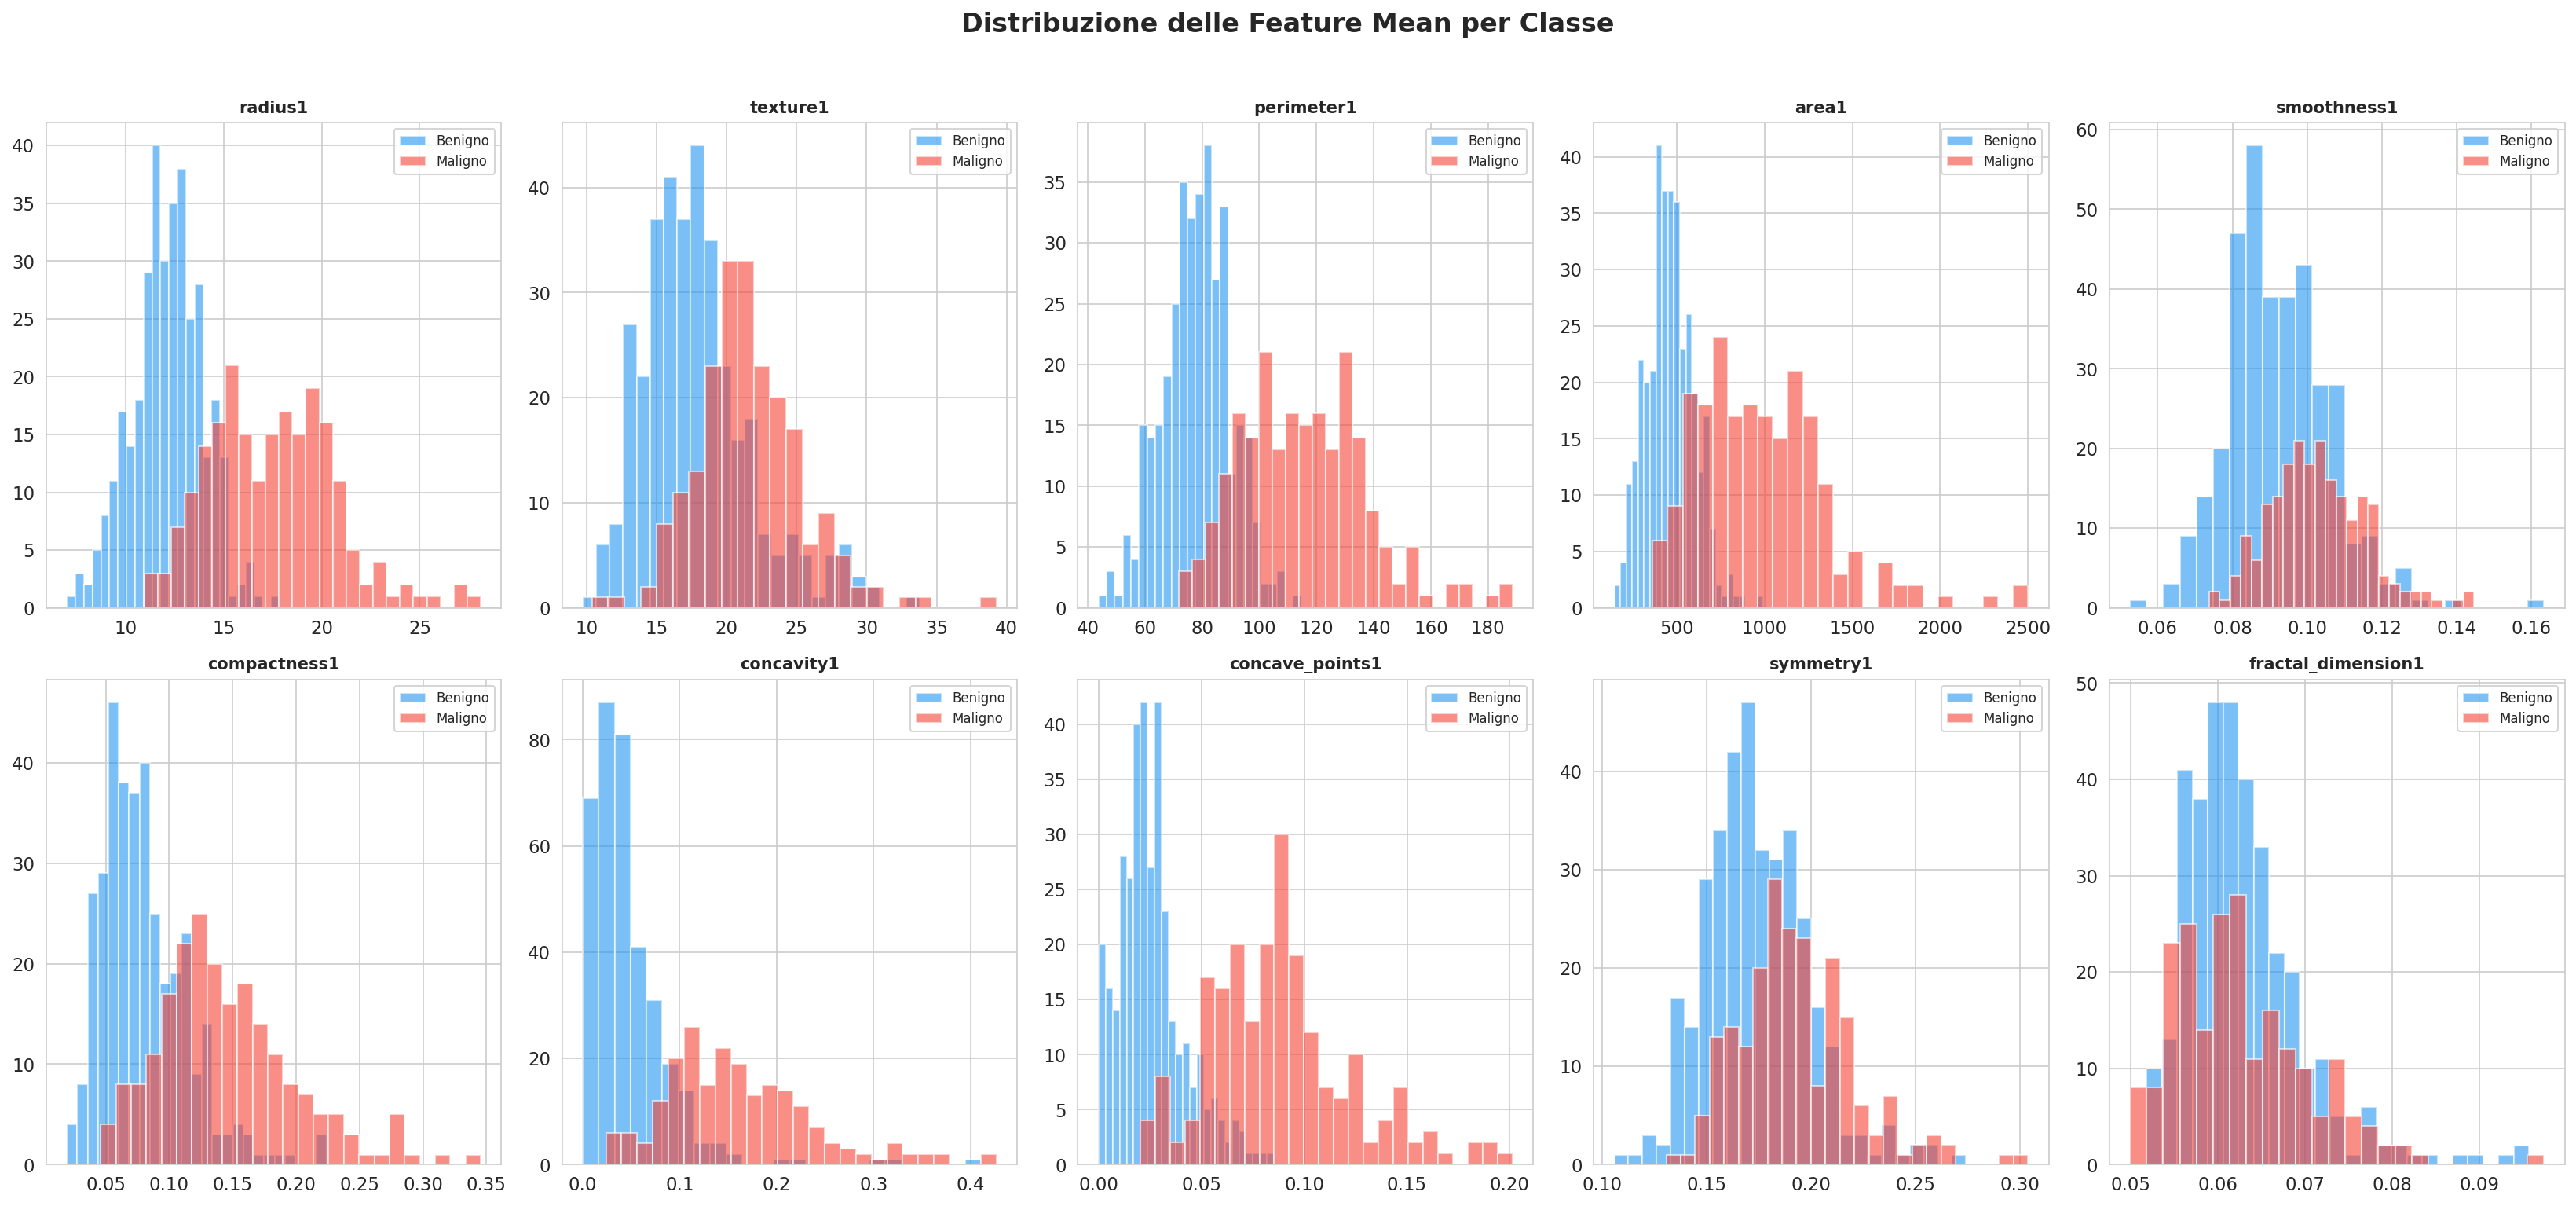

In [7]:
# Istogrammi delle 10 feature mean per classe
mean_cols = list(X.columns[:10])

fig, axes = plt.subplots(2, 5, figsize=(22, 10))
axes = axes.ravel()

for i, col in enumerate(mean_cols):
    for cls, color, label in [('B', '#2196F3', 'Benigno'), ('M', '#F44336', 'Maligno')]:
        data = df[df['Diagnosis'] == cls][col]
        axes[i].hist(data, bins=25, alpha=0.6, color=color, label=label, edgecolor='white')
    axes[i].set_title(col, fontweight='bold', fontsize=10)
    axes[i].legend(fontsize=8)

fig.suptitle('Distribuzione delle Feature Mean per Classe', fontweight='bold', fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig('02_distribuzioni_feature.png', dpi=300, bbox_inches='tight')
plt.show()

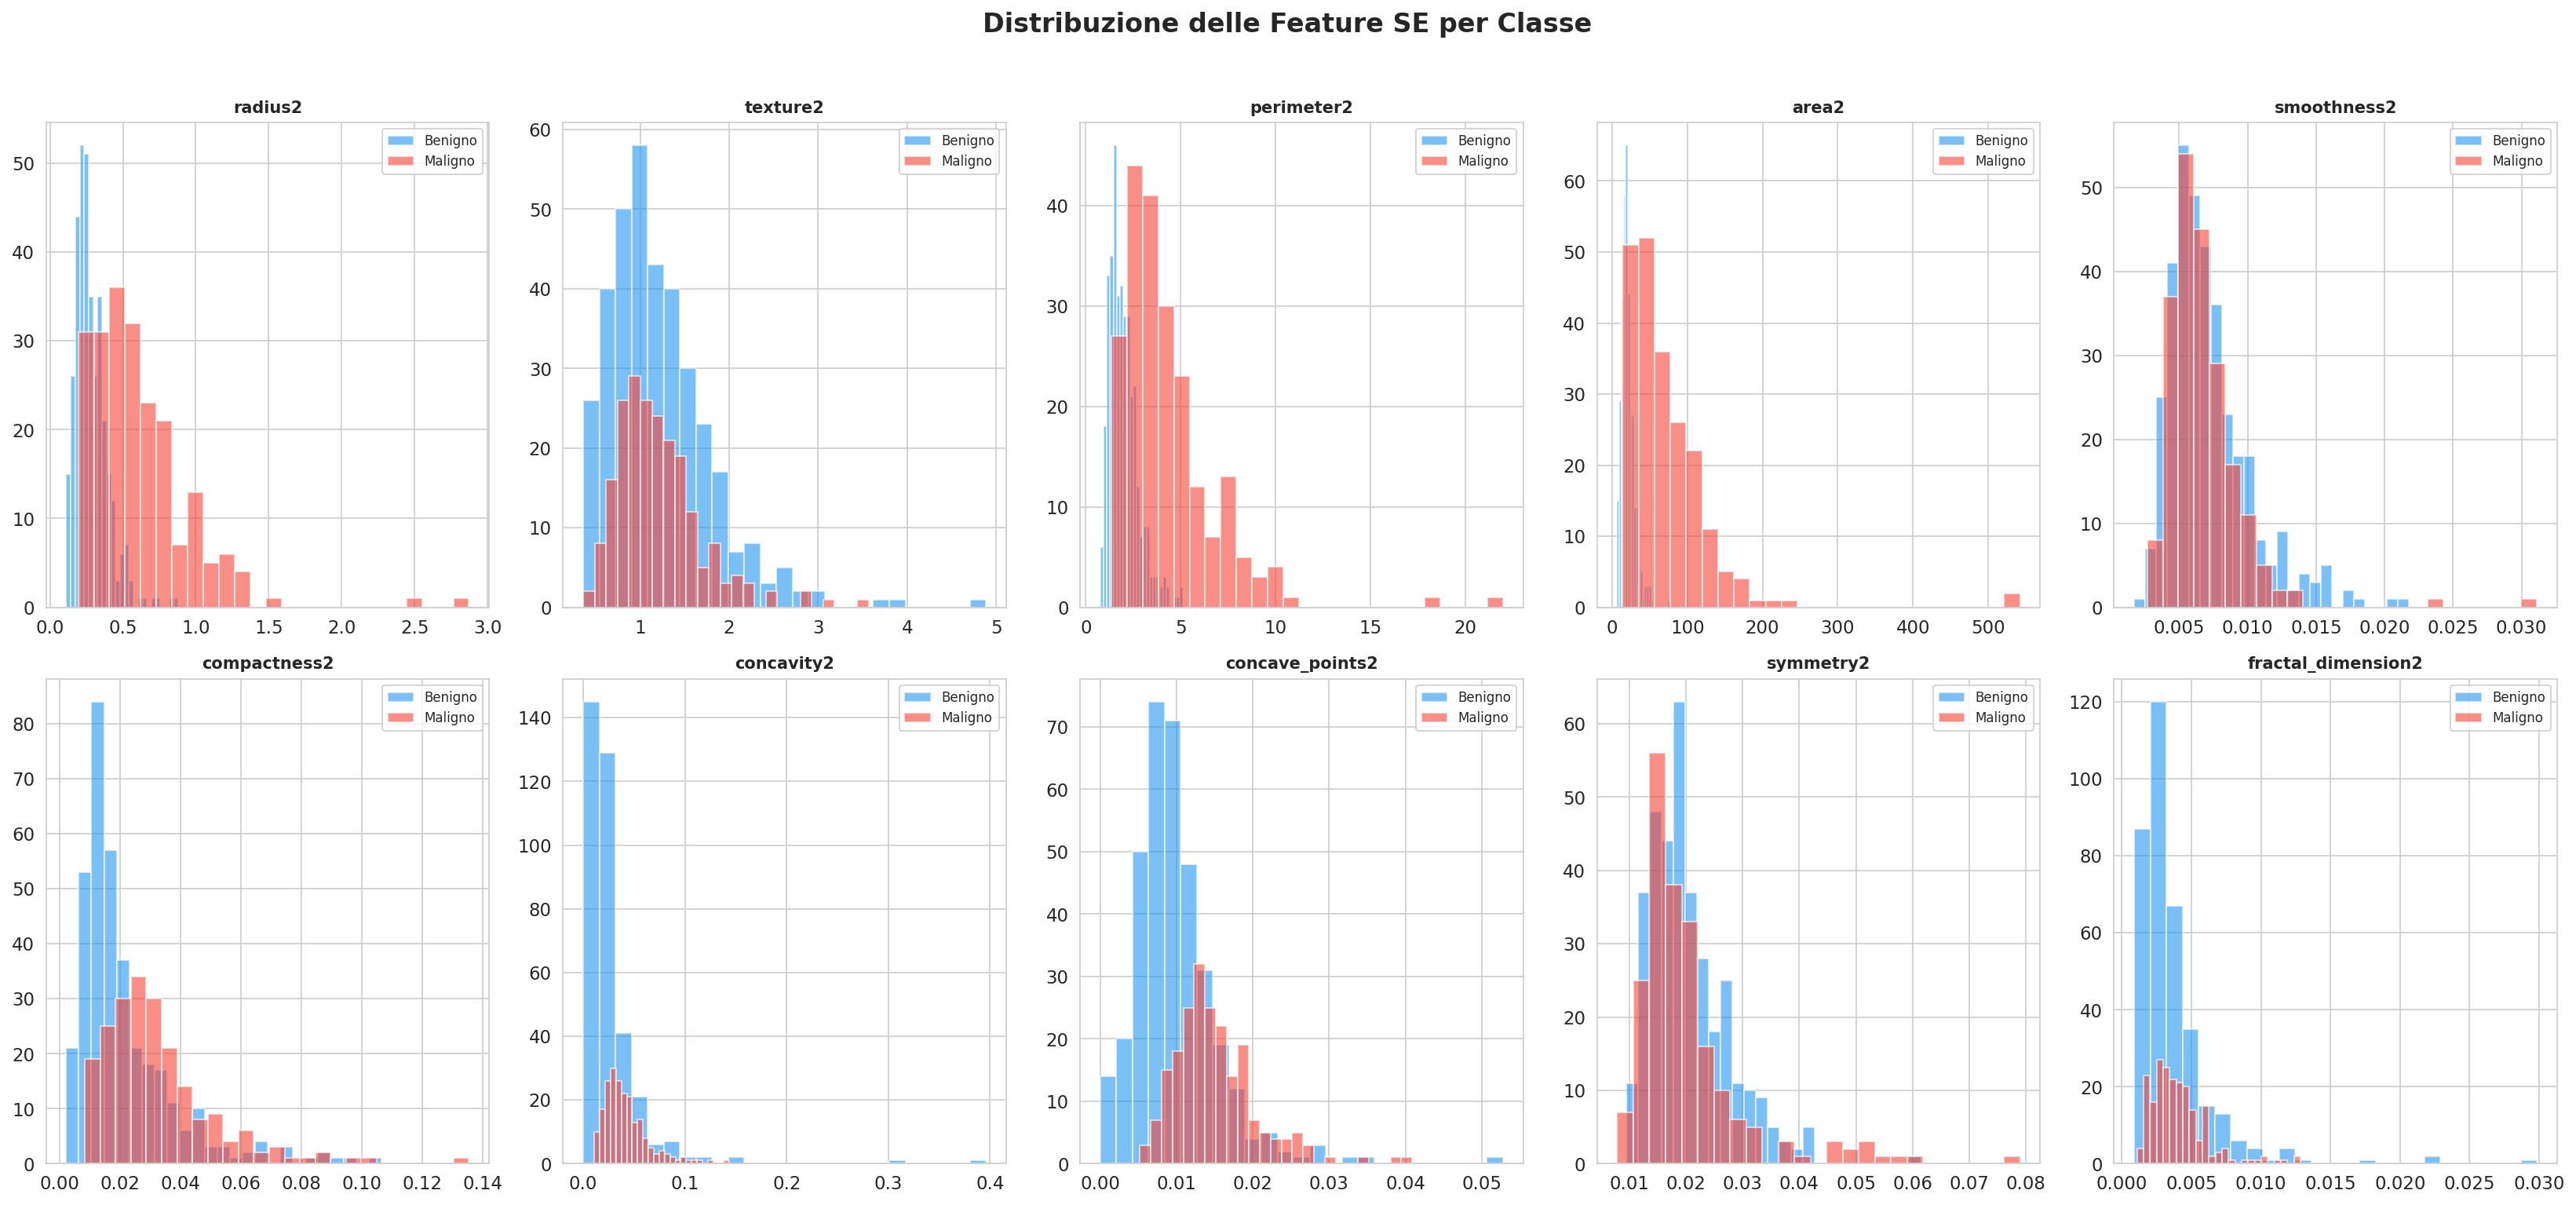

In [8]:
# Istogrammi delle 10 feature SE per classe
se_cols = list(X.columns[10:20])

fig, axes = plt.subplots(2, 5, figsize=(22, 10))
axes = axes.ravel()

for i, col in enumerate(se_cols):
    for cls, color, label in [('B', '#2196F3', 'Benigno'), ('M', '#F44336', 'Maligno')]:
        data = df[df['Diagnosis'] == cls][col]
        axes[i].hist(data, bins=25, alpha=0.6, color=color, label=label, edgecolor='white')
    axes[i].set_title(col, fontweight='bold', fontsize=10)
    axes[i].legend(fontsize=8)

fig.suptitle('Distribuzione delle Feature SE per Classe', fontweight='bold', fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig('02b_distribuzioni_feature_se.png', dpi=300, bbox_inches='tight')
plt.show()

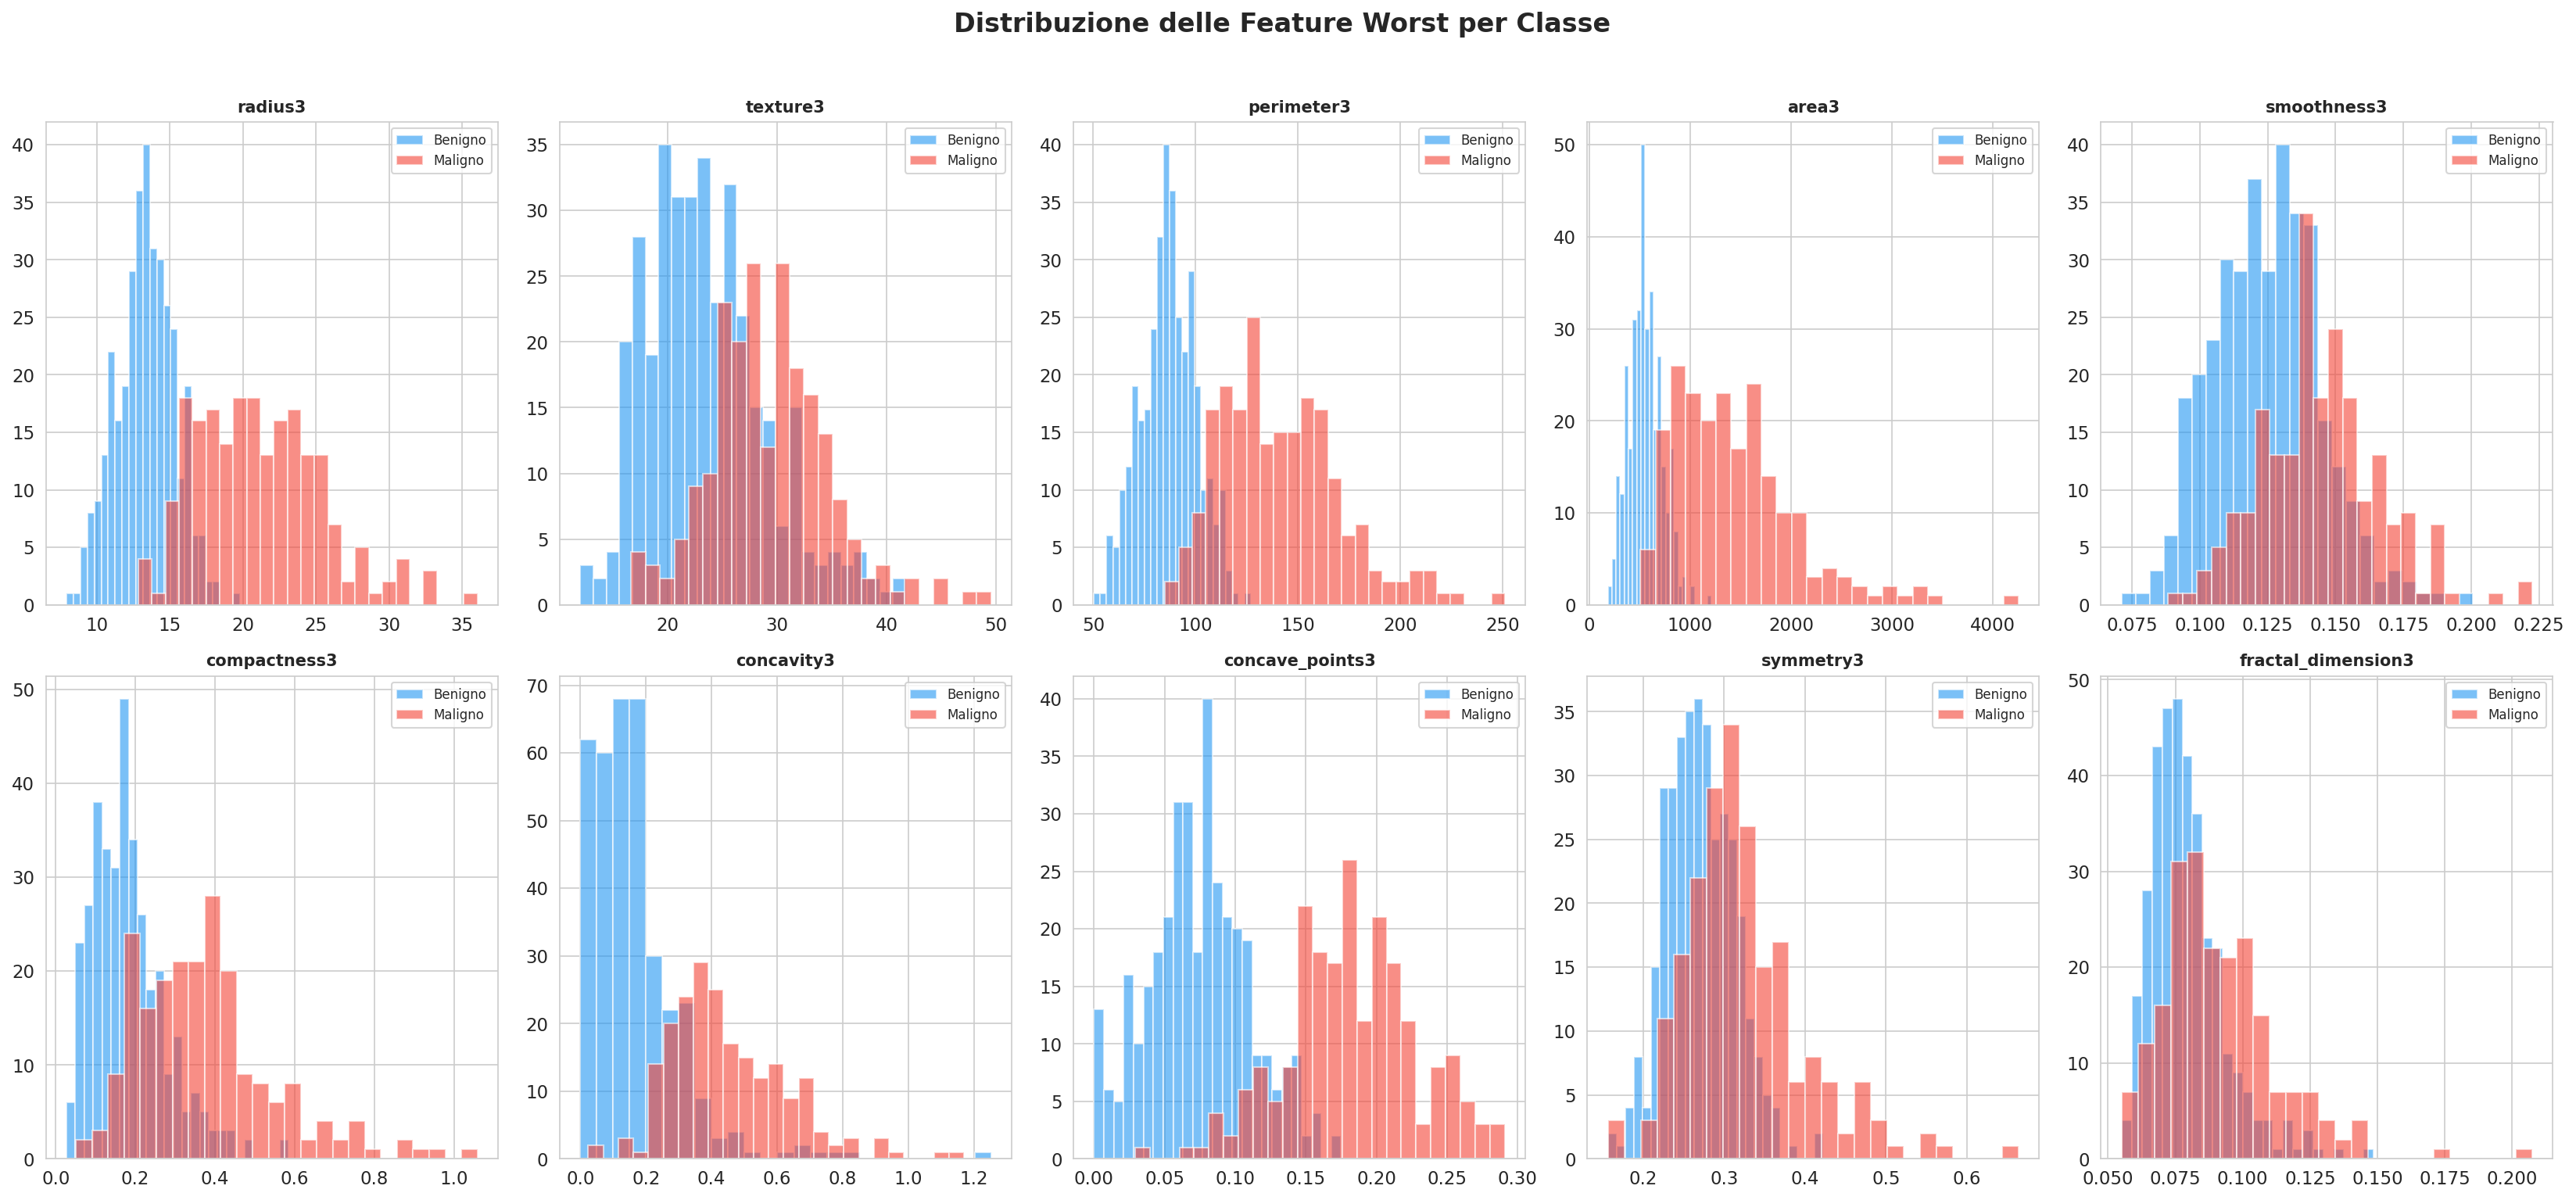

In [9]:
# Istogrammi delle 10 feature Worst per classe
worst_cols = list(X.columns[20:30])

fig, axes = plt.subplots(2, 5, figsize=(22, 10))
axes = axes.ravel()

for i, col in enumerate(worst_cols):
    for cls, color, label in [('B', '#2196F3', 'Benigno'), ('M', '#F44336', 'Maligno')]:
        data = df[df['Diagnosis'] == cls][col]
        axes[i].hist(data, bins=25, alpha=0.6, color=color, label=label, edgecolor='white')
    axes[i].set_title(col, fontweight='bold', fontsize=10)
    axes[i].legend(fontsize=8)

fig.suptitle('Distribuzione delle Feature Worst per Classe', fontweight='bold', fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig('02c_distribuzioni_feature_worst.png', dpi=300, bbox_inches='tight')
plt.show()

/tmp/ipython-input-467752892.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[i].boxplot([data_b, data_m], labels=['Benigno', 'Maligno'],
/tmp/ipython-input-467752892.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[i].boxplot([data_b, data_m], labels=['Benigno', 'Maligno'],
/tmp/ipython-input-467752892.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[i].boxplot([data_b, data_m], labels=['Benigno', 'Maligno'],
/tmp/ipython-input-467752892.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the ol

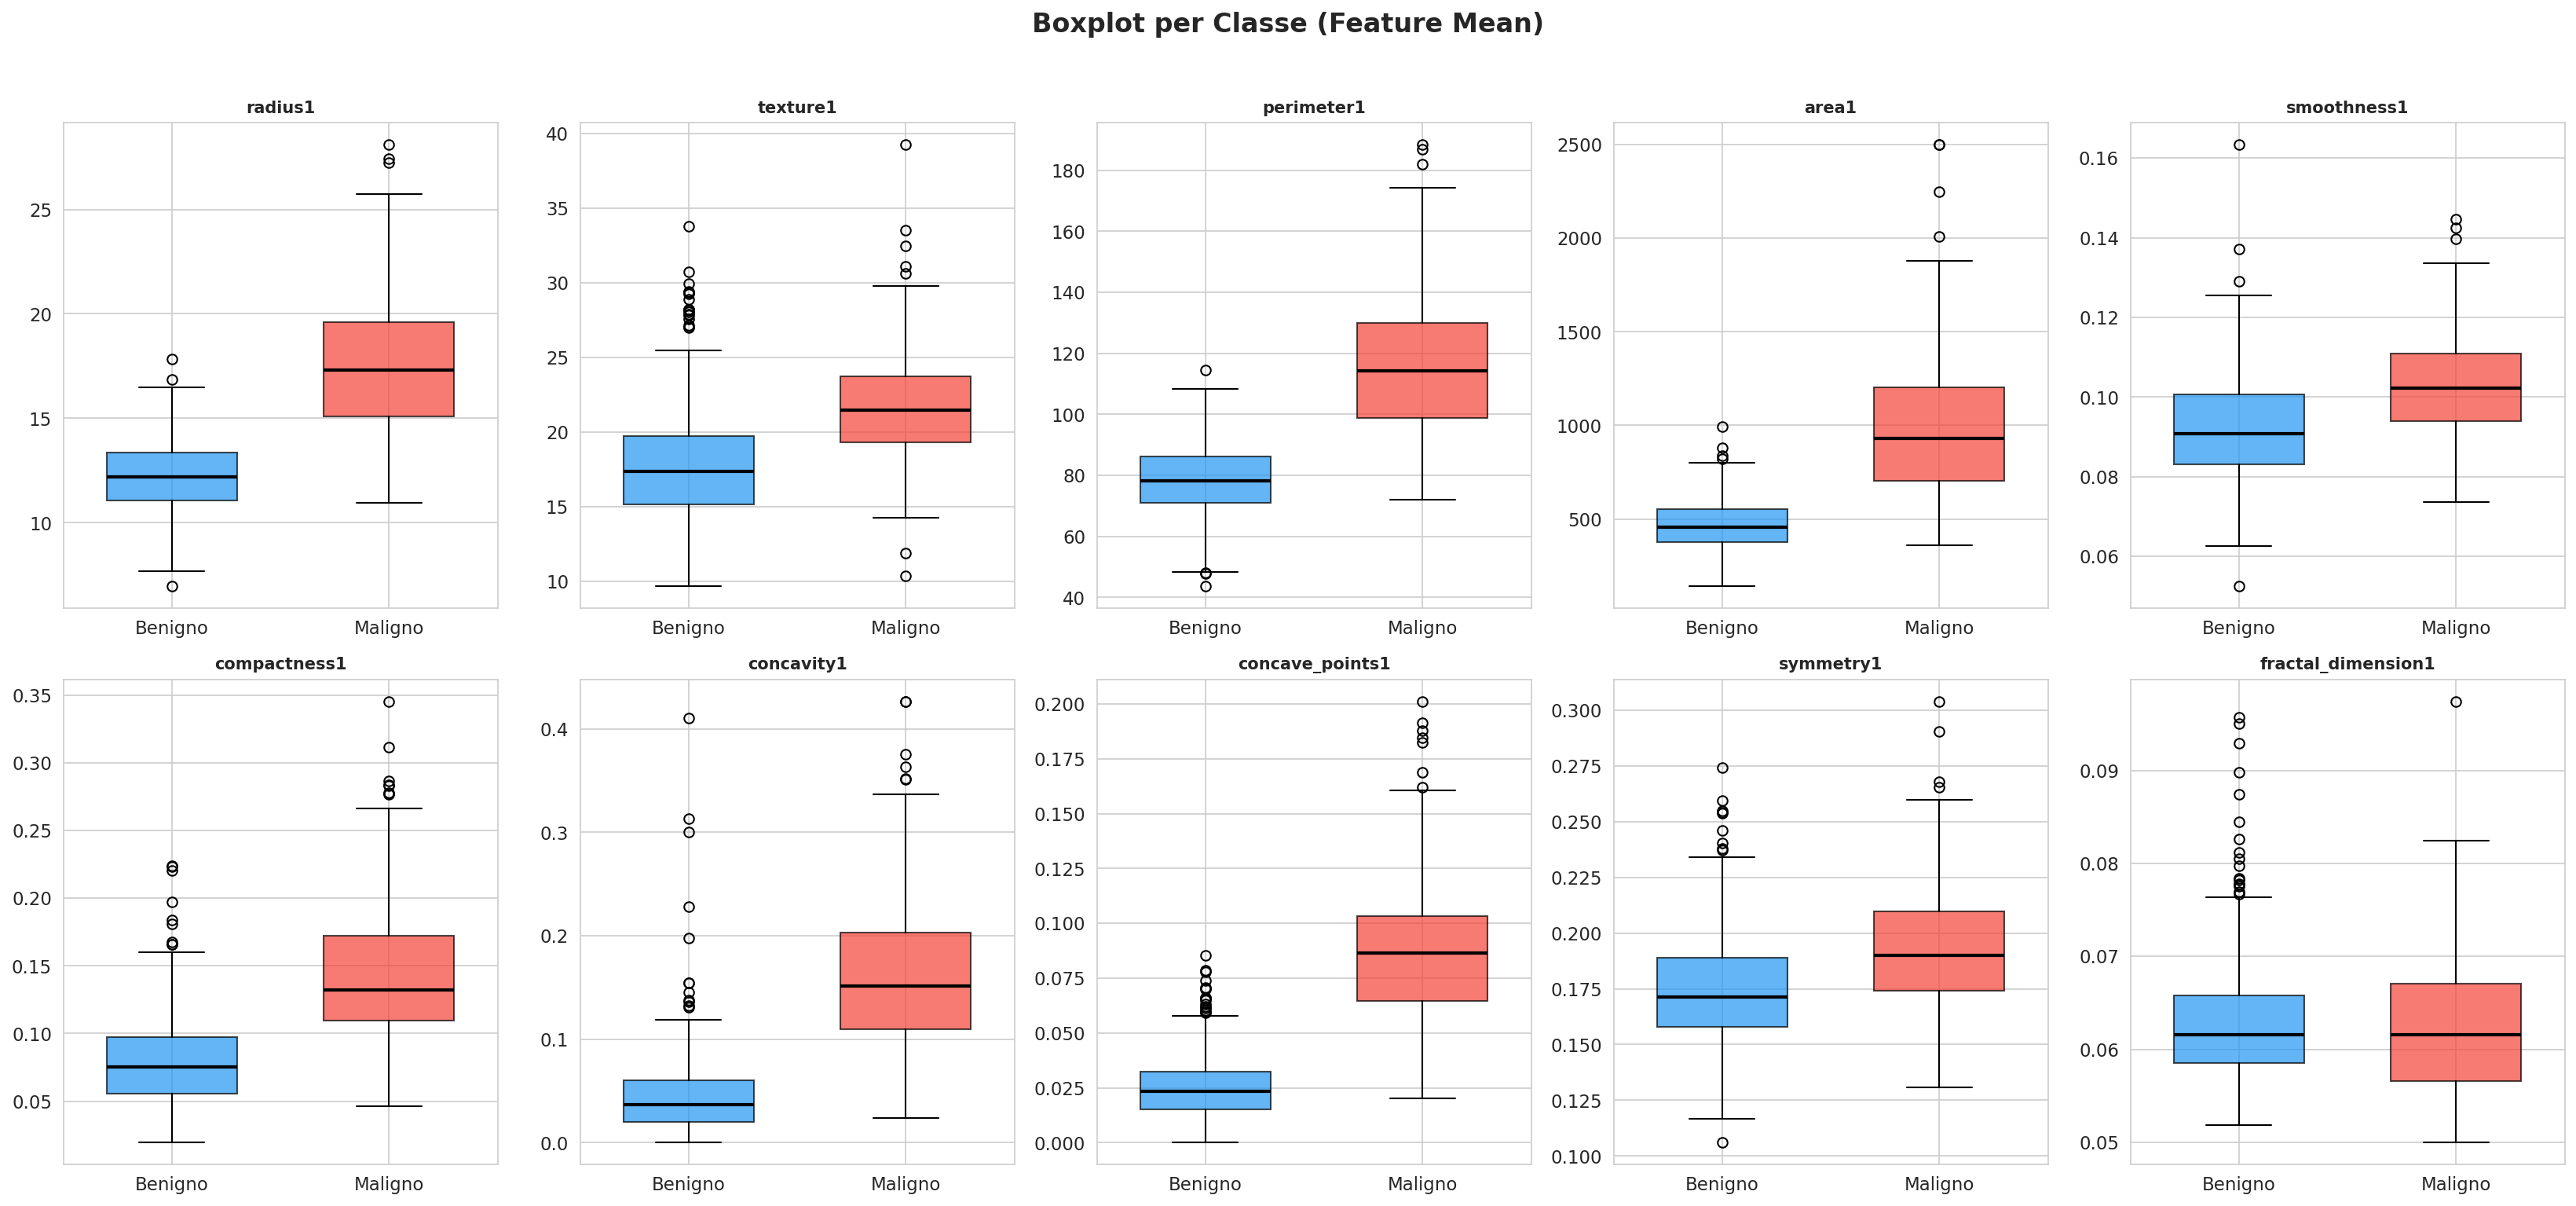

In [10]:
# Boxplot comparativi per classe
# TODO Teoricamente farli per tutte e 3 le tipologie
fig, axes = plt.subplots(2, 5, figsize=(22, 10))
axes = axes.ravel()

for i, col in enumerate(mean_cols):
    data_b = df[df['Diagnosis'] == 'B'][col]
    data_m = df[df['Diagnosis'] == 'M'][col]
    bp = axes[i].boxplot([data_b, data_m], labels=['Benigno', 'Maligno'],
                         patch_artist=True, widths=0.6,
                         medianprops=dict(color='black', linewidth=2))
    bp['boxes'][0].set_facecolor('#2196F3')
    bp['boxes'][0].set_alpha(0.7)
    bp['boxes'][1].set_facecolor('#F44336')
    bp['boxes'][1].set_alpha(0.7)
    axes[i].set_title(col, fontweight='bold', fontsize=10)

fig.suptitle('Boxplot per Classe (Feature Mean)', fontweight='bold', fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig('03_boxplot_feature.png', dpi=300, bbox_inches='tight')
plt.show()

### 3.5 Analisi delle Correlazioni

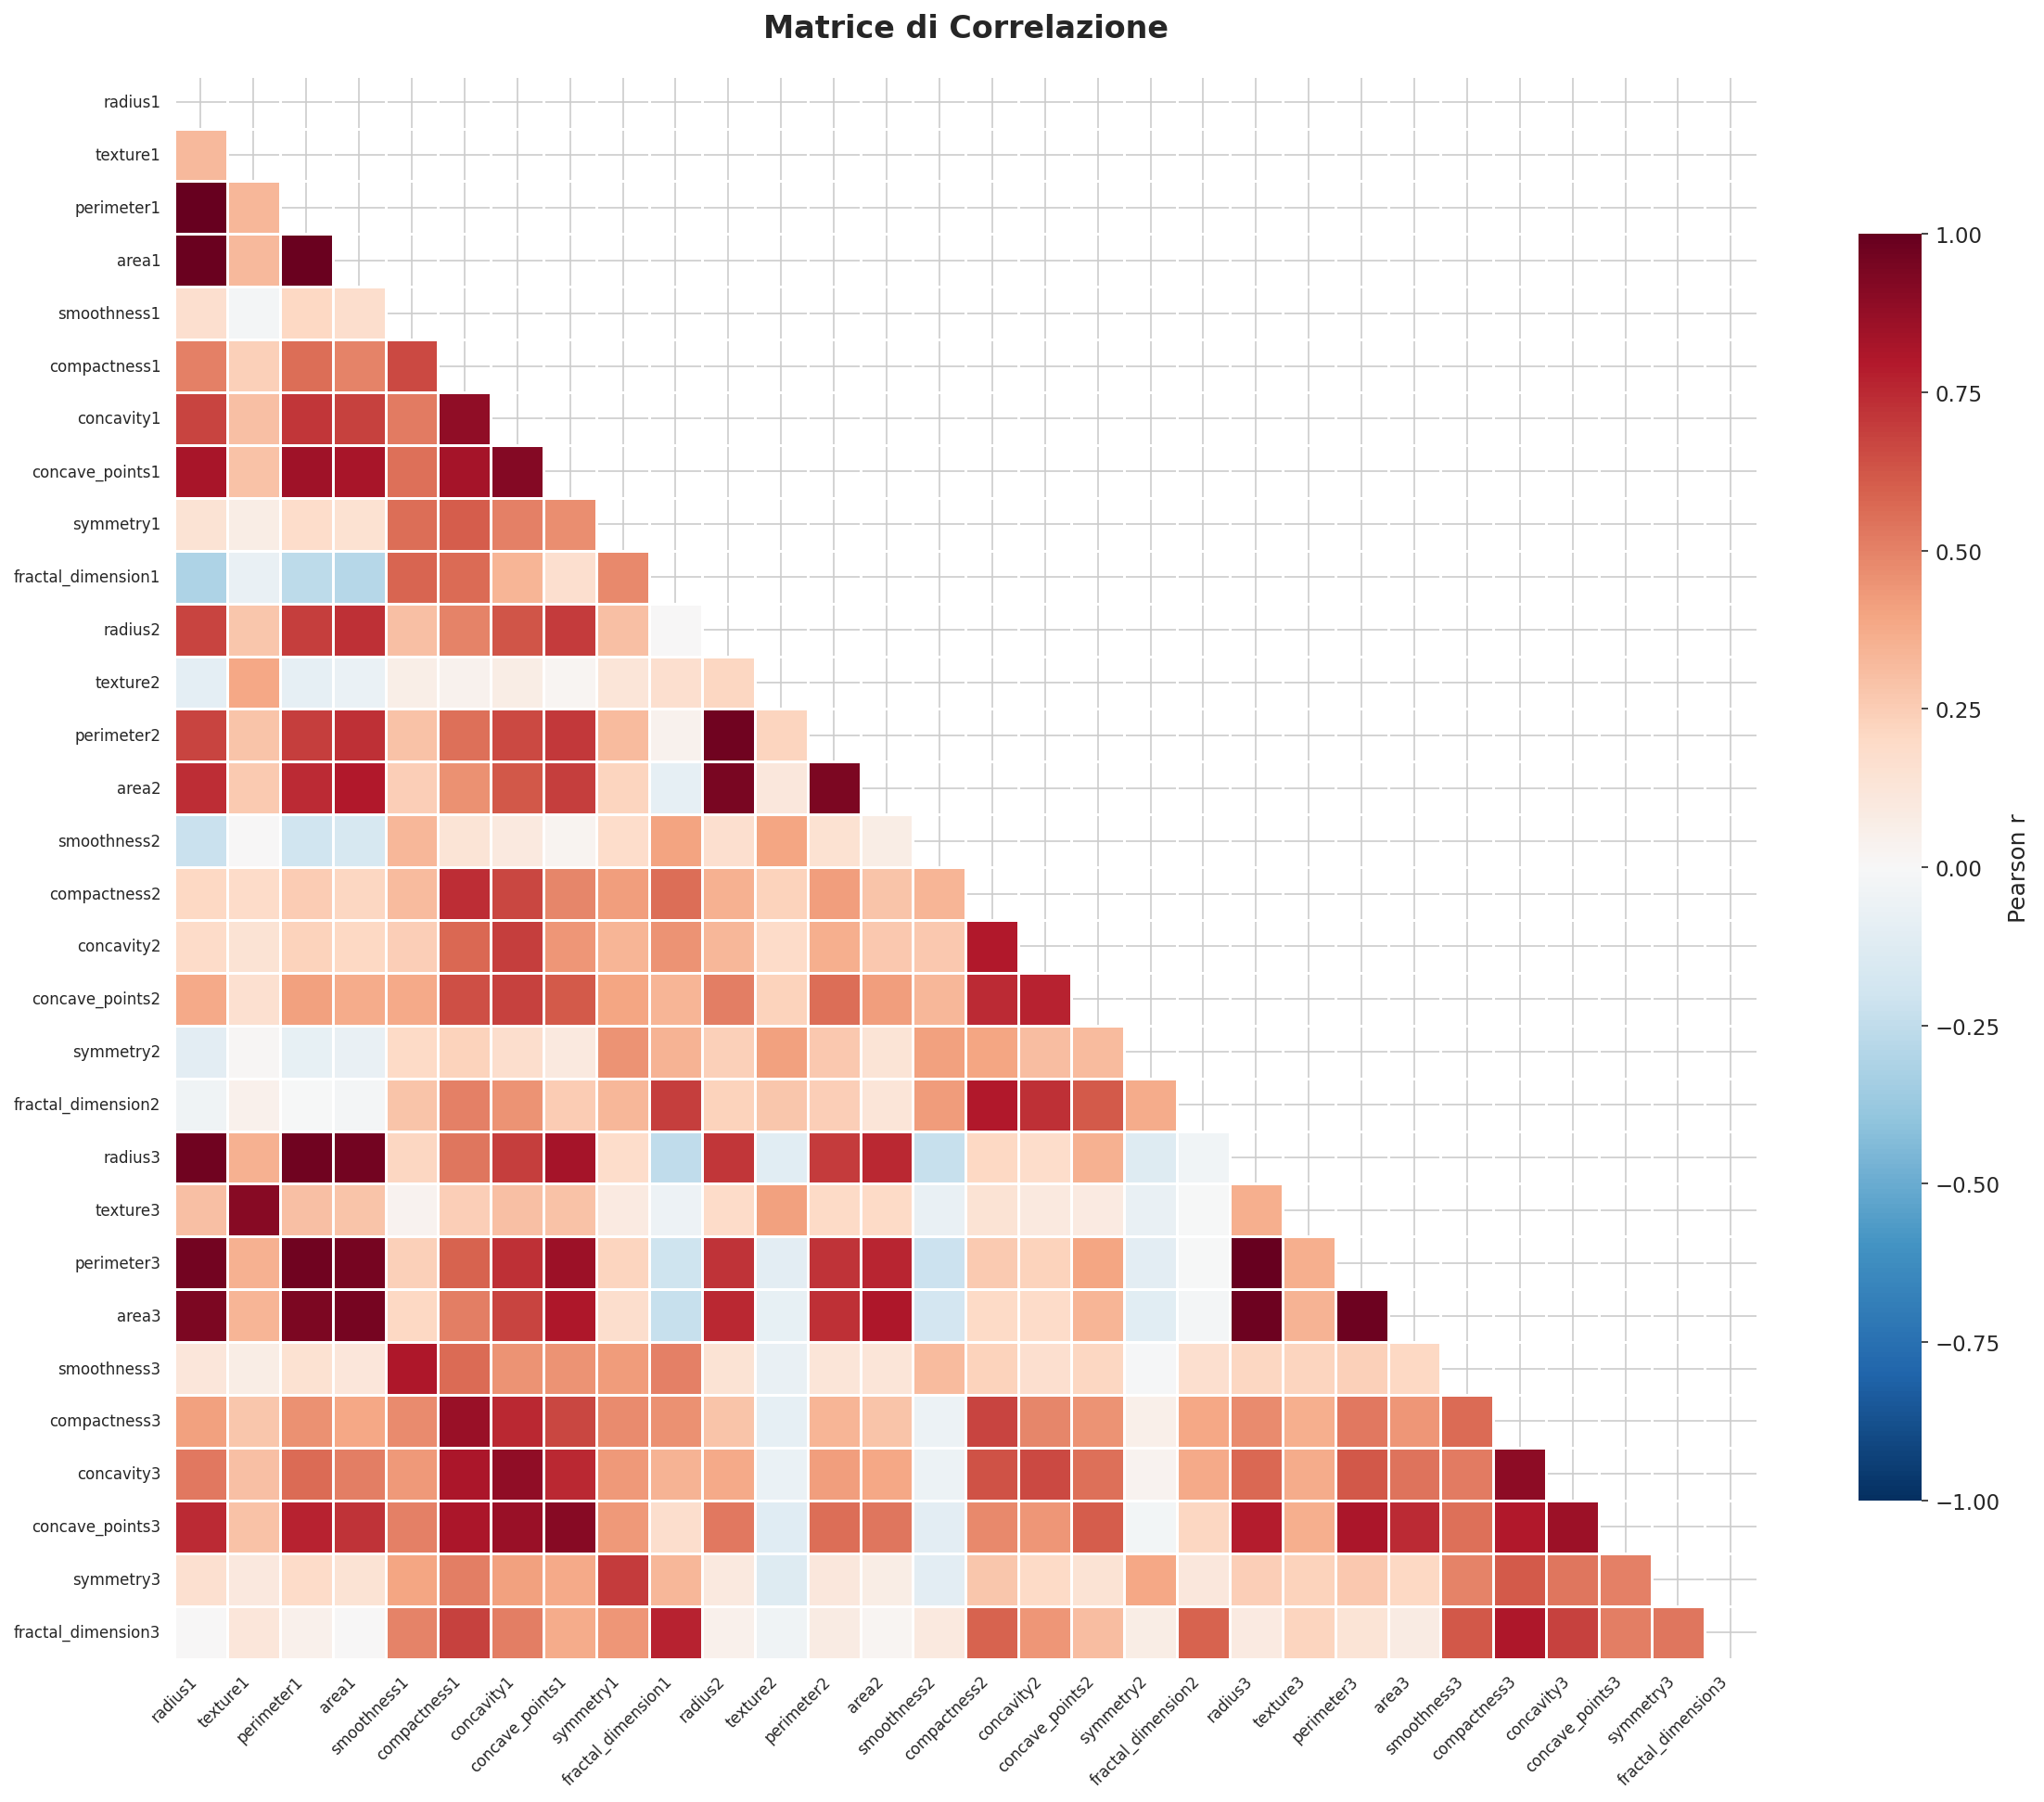

Top 10 coppie piu' correlate:


,Feature 1,Feature 2,|r|
0,radius1,perimeter1,0.997855
1,radius3,perimeter3,0.993708
2,radius1,area1,0.987357
3,perimeter1,area1,0.986507
4,radius3,area3,0.984015
5,perimeter3,area3,0.977578
6,radius2,perimeter2,0.972794
7,perimeter1,perimeter3,0.970387
8,radius1,radius3,0.969539
9,perimeter1,radius3,0.969476


In [11]:
corr_matrix = X.corr()

fig, ax = plt.subplots(figsize=(16, 13))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, cmap='RdBu_r', center=0, vmin=-1, vmax=1,
            square=True, linewidths=0.5, ax=ax,
            cbar_kws={'shrink': 0.8, 'label': 'Pearson r'})
ax.set_title('Matrice di Correlazione', fontweight='bold', fontsize=16, pad=20)
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.savefig('04_matrice_correlazione.png', dpi=300, bbox_inches='tight')
plt.show()

# Top coppie correlate
upper = corr_matrix.where(np.triu(np.ones_like(corr_matrix, dtype=bool), k=1))
pairs = []
for col in upper.columns:
    for idx in upper.index:
        val = upper.loc[idx, col]
        if pd.notna(val):
            pairs.append((idx, col, abs(val)))

# TODO Gestire meglio questa parte
pairs_df = pd.DataFrame(pairs, columns=['Feature 1', 'Feature 2', '|r|'])
pairs_df = pairs_df.sort_values('|r|', ascending=False)
print('Top 10 coppie piu\' correlate:')
display(pairs_df.head(30).reset_index(drop=True))

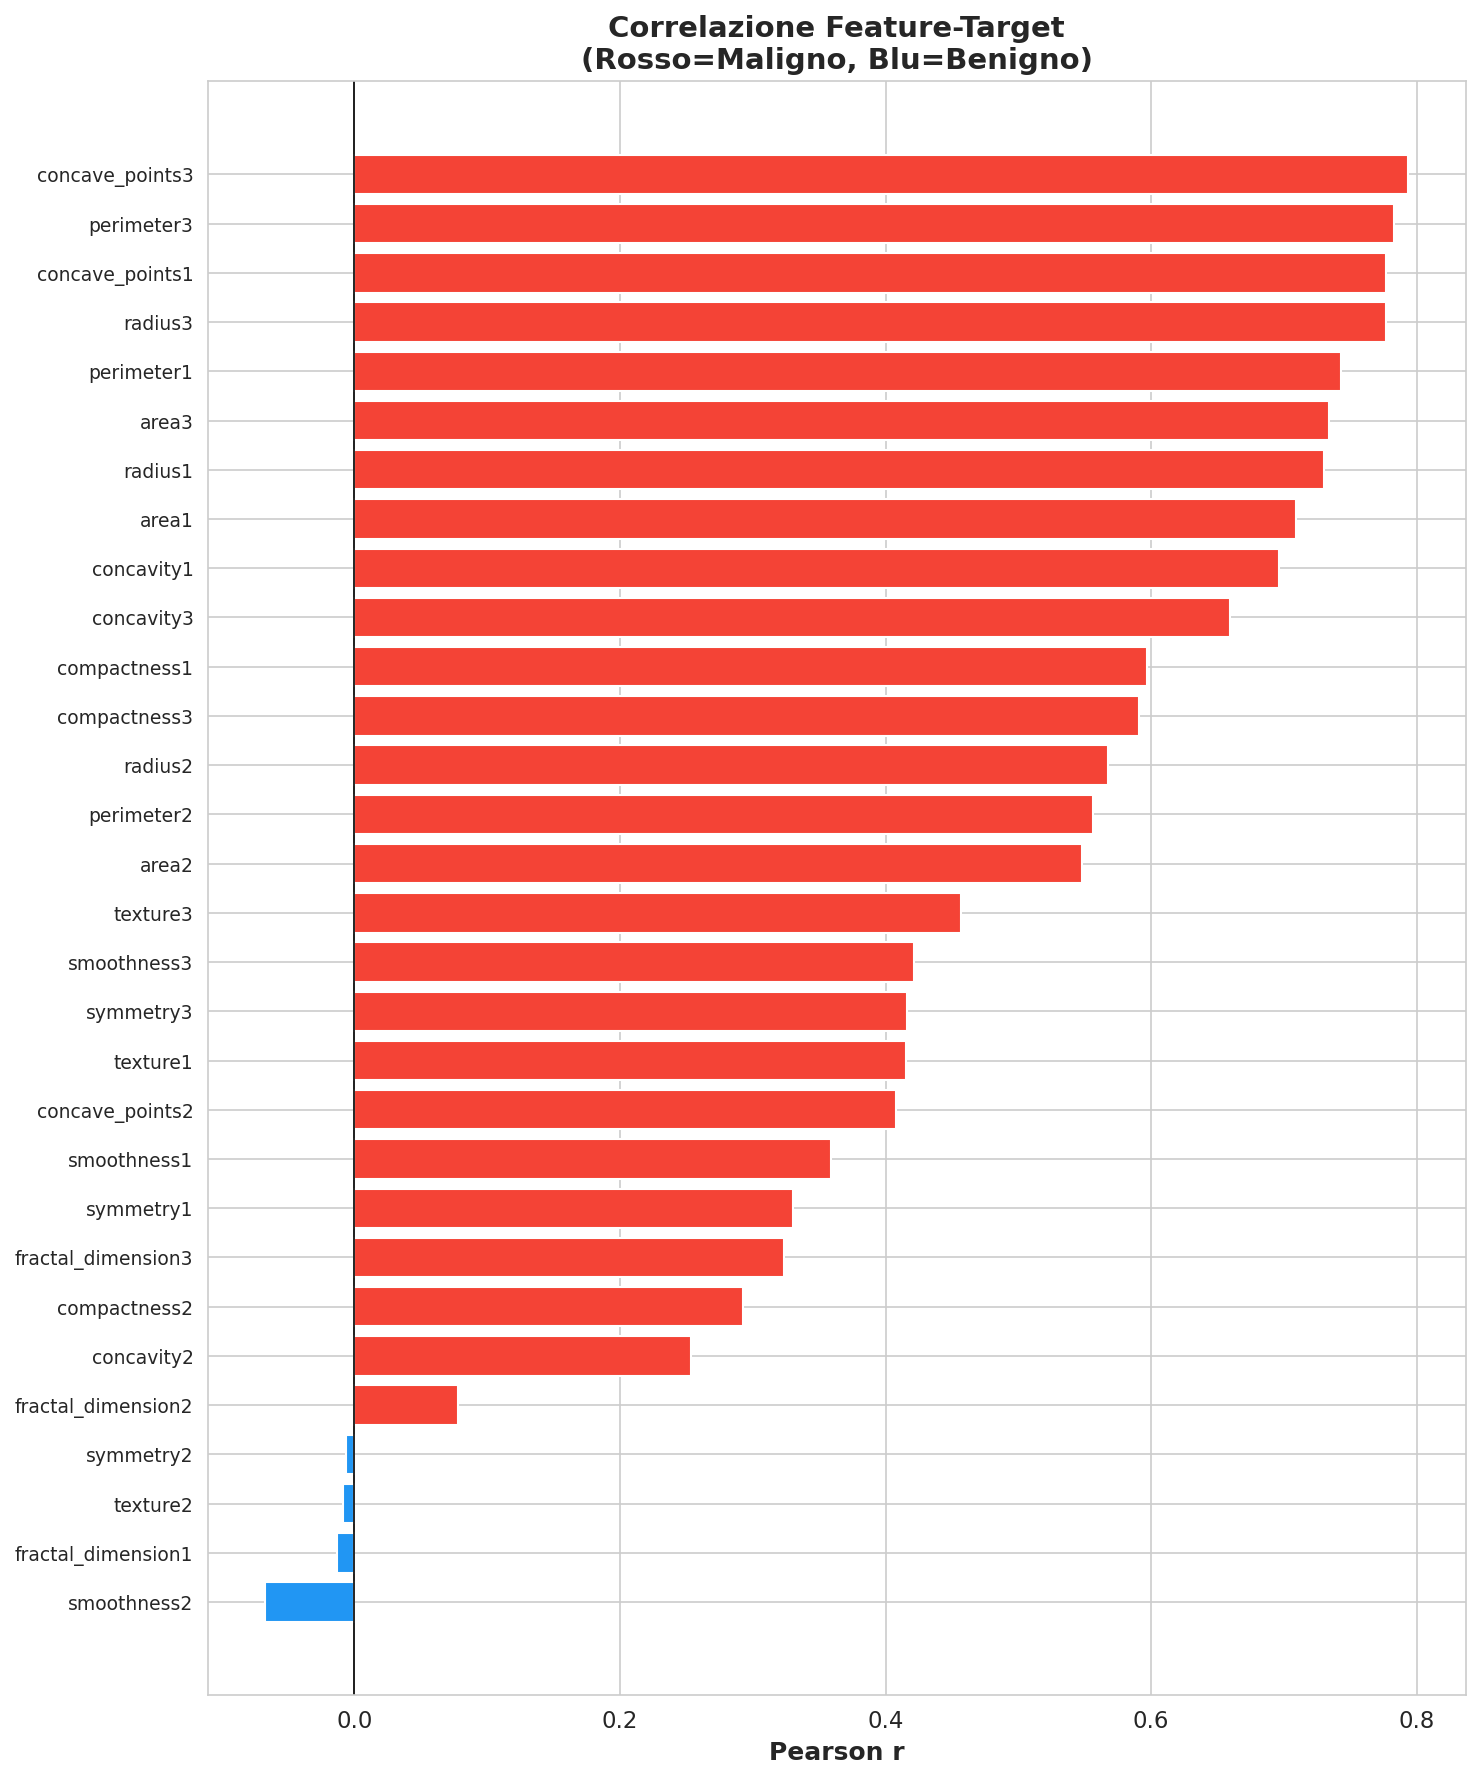

In [12]:
# Correlazione con il target
corr_target = X.corrwith(pd.Series(y, index=X.index)).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(10, 12))
colors_bar = ['#F44336' if v > 0 else '#2196F3' for v in corr_target.values]
ax.barh(range(len(corr_target)), corr_target.values, color=colors_bar)
ax.set_yticks(range(len(corr_target)))
ax.set_yticklabels(corr_target.index, fontsize=9)
ax.set_xlabel('Pearson r', fontweight='bold')
ax.set_title('Correlazione Feature-Target\n(Rosso=Maligno, Blu=Benigno)', fontweight='bold')
ax.axvline(x=0, color='black', linewidth=0.8)
ax.invert_yaxis()
plt.tight_layout()
plt.savefig('05_correlazione_target.png', dpi=300, bbox_inches='tight')
plt.show()

### 3.6 Identificazione Outlier

In [13]:
def count_outliers_iqr(series, k=1.5):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    return ((series < Q1 - k * IQR) | (series > Q3 + k * IQR)).sum()

outlier_counts = X.apply(count_outliers_iqr)
outlier_pct = (outlier_counts / len(X) * 100).round(2)

outlier_df = pd.DataFrame({
    'Feature': outlier_counts.index,
    'N. Outlier': outlier_counts.values,
    '% Outlier': outlier_pct.values
}).sort_values('N. Outlier', ascending=False)

display(outlier_df.head(30).reset_index(drop=True))

,Feature,N. Outlier,% Outlier
0,area2,65,11.42
1,radius2,38,6.68
2,perimeter2,38,6.68
3,area3,35,6.15
4,smoothness2,30,5.27
5,fractal_dimension2,28,4.92
6,compactness2,28,4.92
7,symmetry2,27,4.75
8,area1,25,4.39
9,fractal_dimension3,24,4.22


### 3.7 Pairplot Feature Principali

Top 5 feature per pairplot: ['concave_points3', 'perimeter3', 'concave_points1', 'radius3', 'perimeter1']


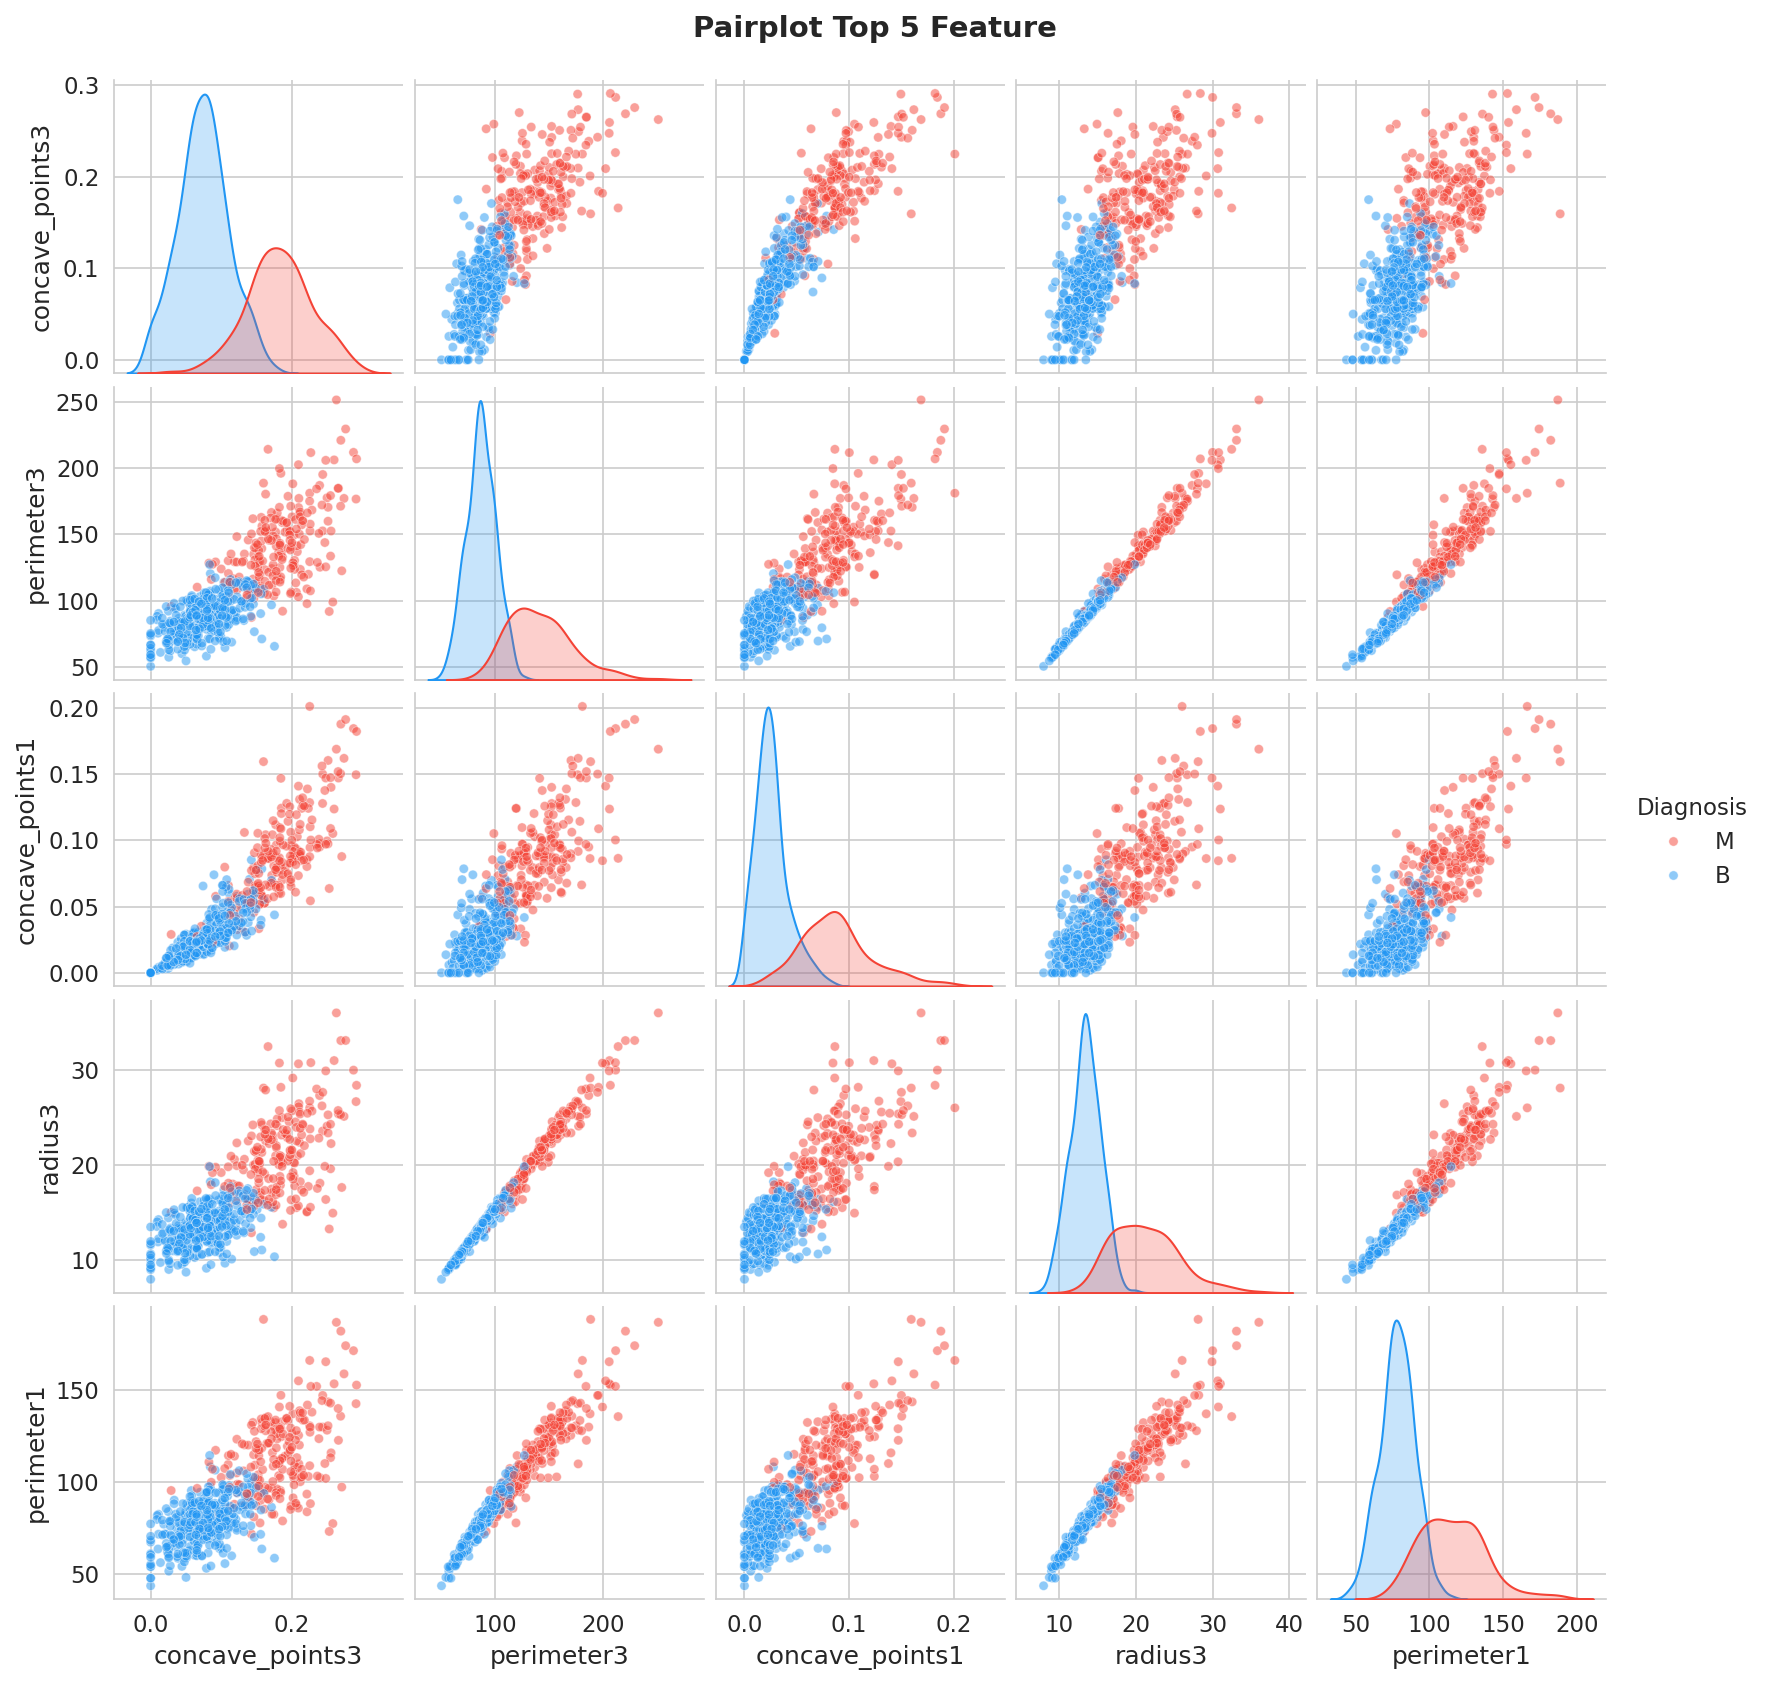

In [14]:
# TODO Decidere se lasciare i pairplot o meno
top5 = corr_target.abs().sort_values(ascending=False).head(5).index.tolist()
print(f'Top 5 feature per pairplot: {top5}')

g = sns.pairplot(df[top5 + ['Diagnosis']], hue='Diagnosis',
                 palette={'B': '#2196F3', 'M': '#F44336'},
                 diag_kind='kde', plot_kws={'alpha': 0.5, 's': 20}, height=2.2)
g.figure.suptitle('Pairplot Top 5 Feature', fontweight='bold', fontsize=14, y=1.02)
plt.savefig('06_pairplot.png', dpi=200, bbox_inches='tight')
plt.show()

### 3.8 Analisi PCA — Varianza Spiegata e Scelta delle Componenti

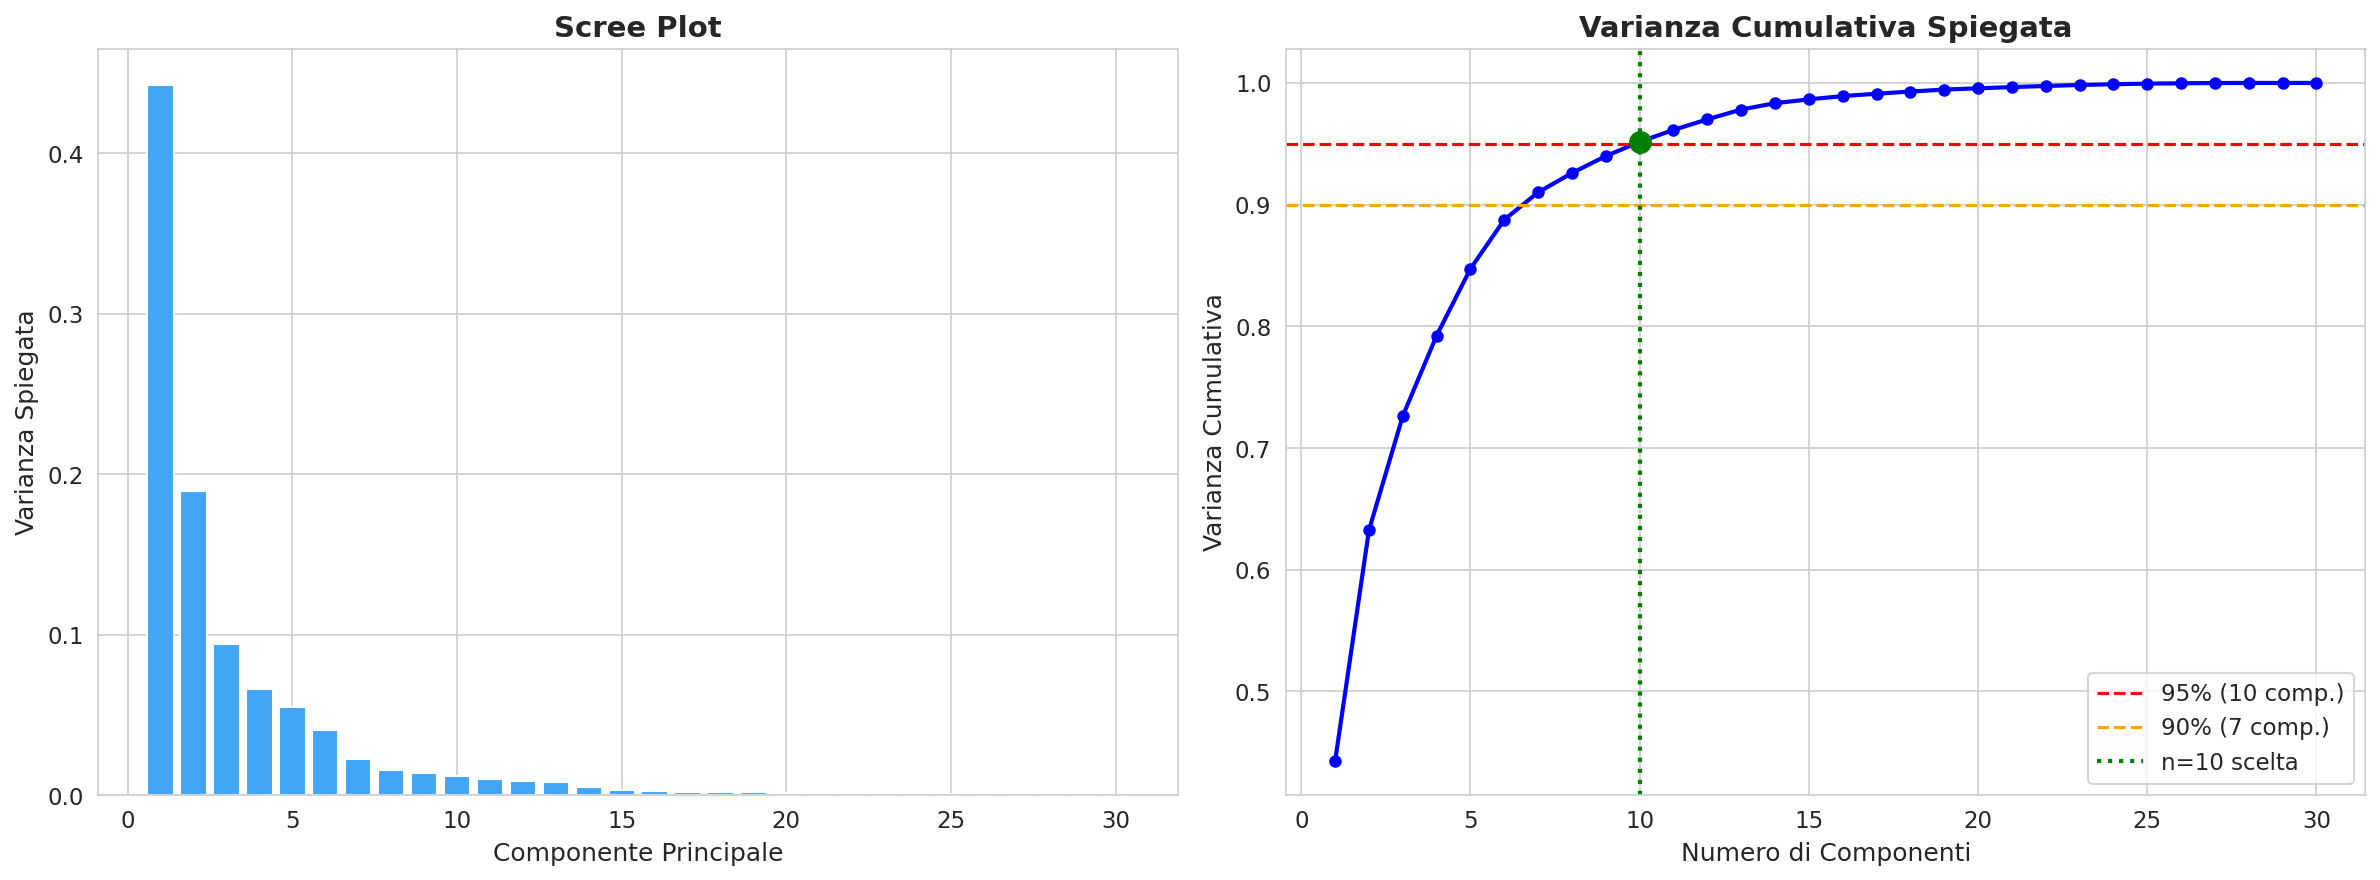

Componenti per 90% varianza: 7
Componenti per 95% varianza: 10
Varianza con 10 componenti:  95.16%
Varianza con 2 componenti:   63.24%


In [15]:
scaler_eda = StandardScaler()
X_scaled_eda = scaler_eda.fit_transform(X)

pca_eda = PCA()
pca_eda.fit(X_scaled_eda)
cumvar_eda = np.cumsum(pca_eda.explained_variance_ratio_)

n_95_eda = np.argmax(cumvar_eda >= 0.95) + 1
n_90_eda = np.argmax(cumvar_eda >= 0.90) + 1

# Grafico: Scree Plot + Varianza Cumulativa
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].bar(range(1, 31), pca_eda.explained_variance_ratio_,
            color='#42A5F5', edgecolor='white')
axes[0].set_xlabel('Componente Principale')
axes[0].set_ylabel('Varianza Spiegata')
axes[0].set_title('Scree Plot', fontweight='bold')

axes[1].plot(range(1, 31), cumvar_eda, 'bo-', linewidth=2, markersize=5)
axes[1].axhline(y=0.95, color='r', linestyle='--', label=f'95% ({n_95_eda} comp.)')
axes[1].axhline(y=0.90, color='orange', linestyle='--', label=f'90% ({n_90_eda} comp.)')
axes[1].axvline(x=10, color='green', linestyle=':', linewidth=2, label=f'n=10 scelta')
axes[1].scatter([10], [cumvar_eda[9]], color='green', s=100, zorder=5)
axes[1].set_xlabel('Numero di Componenti')
axes[1].set_ylabel('Varianza Cumulativa')
axes[1].set_title('Varianza Cumulativa Spiegata', fontweight='bold')
axes[1].legend()

plt.tight_layout()
plt.savefig('06b_pca_varianza_eda.png', dpi=300, bbox_inches='tight')
plt.show()

# Tabella riassuntiva
print(f'Componenti per 90% varianza: {n_90_eda}')
print(f'Componenti per 95% varianza: {n_95_eda}')
print(f'Varianza con 10 componenti:  {cumvar_eda[9]*100:.2f}%')
print(f'Varianza con 2 componenti:   {cumvar_eda[1]*100:.2f}%')

---
## 4. Modelli

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)

print(f'Training: {X_train.shape[0]} campioni ({X_train.shape[0]/len(X)*100:.0f}%)')
print(f'Test:     {X_test.shape[0]} campioni ({X_test.shape[0]/len(X)*100:.0f}%)')
print(f'\nDistribuzione classi:')
print(f'  Training - B: {(y_train==0).sum()}, M: {(y_train==1).sum()}')
print(f'  Test     - B: {(y_test==0).sum()}, M: {(y_test==1).sum()}')

Training: 455 campioni (80%)
Test:     114 campioni (20%)

Distribuzione classi:
  Training - B: 285, M: 170
  Test     - B: 72, M: 42


In [17]:
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=10, random_state=RANDOM_STATE)),
    ('classifier', SVC(
        kernel='rbf',
        class_weight='balanced',
        probability=True,
        random_state=RANDOM_STATE
    ))
])

dt_pipeline = Pipeline([
    ('classifier', DecisionTreeClassifier(
        criterion='gini',
        class_weight='balanced',
        random_state=RANDOM_STATE
    ))
])

pipelines = {
    'SVM (RBF)': svm_pipeline,
    'Decision Tree (CART)': dt_pipeline,
}

print('Pipeline definite:')
for name, pipe in pipelines.items():
    steps = ' -> '.join([s[0] for s in pipe.steps])
    print(f'  {name}: {steps}')

Pipeline definite:
  SVM (RBF): scaler -> pca -> classifier
  Decision Tree (CART): classifier


### 4.1 Cross-Validation (10-Fold Stratificata)

In [18]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)
scoring_metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

cv_results = {}

for name, pipe in pipelines.items():
    cv_res = cross_validate(
        pipe, X_train, y_train,
        cv=cv,
        scoring=scoring_metrics,
        n_jobs=-1
    )
    cv_results[name] = cv_res

    for metric in scoring_metrics:
        key = f'test_{metric}'
        mean = cv_res[key].mean()
        std = cv_res[key].std()
    print()

cv_summary = []
for name in pipelines:
    row = {'Modello': name}
    for metric in scoring_metrics:
        key = f'test_{metric}'
        m = cv_results[name][key].mean()
        s = cv_results[name][key].std()
        row[metric.upper()] = f'{m:.4f} +/- {s:.4f}'
    cv_summary.append(row)

display(pd.DataFrame(cv_summary))

,Modello,ACCURACY,PRECISION,RECALL,F1,ROC_AUC
0,SVM (RBF),0.9648 +/- 0.0298,0.9536 +/- 0.0334,0.9529 +/- 0.0686,0.9520 +/- 0.0425,0.9933 +/- 0.0097
1,Decision Tree (CART),0.9362 +/- 0.0422,0.9079 +/- 0.0518,0.9235 +/- 0.0791,0.9145 +/- 0.0588,0.9337 +/- 0.0487


/tmp/ipython-input-4140513613.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(cv_data, labels=list(pipelines.keys()), patch_artist=True, widths=0.5,


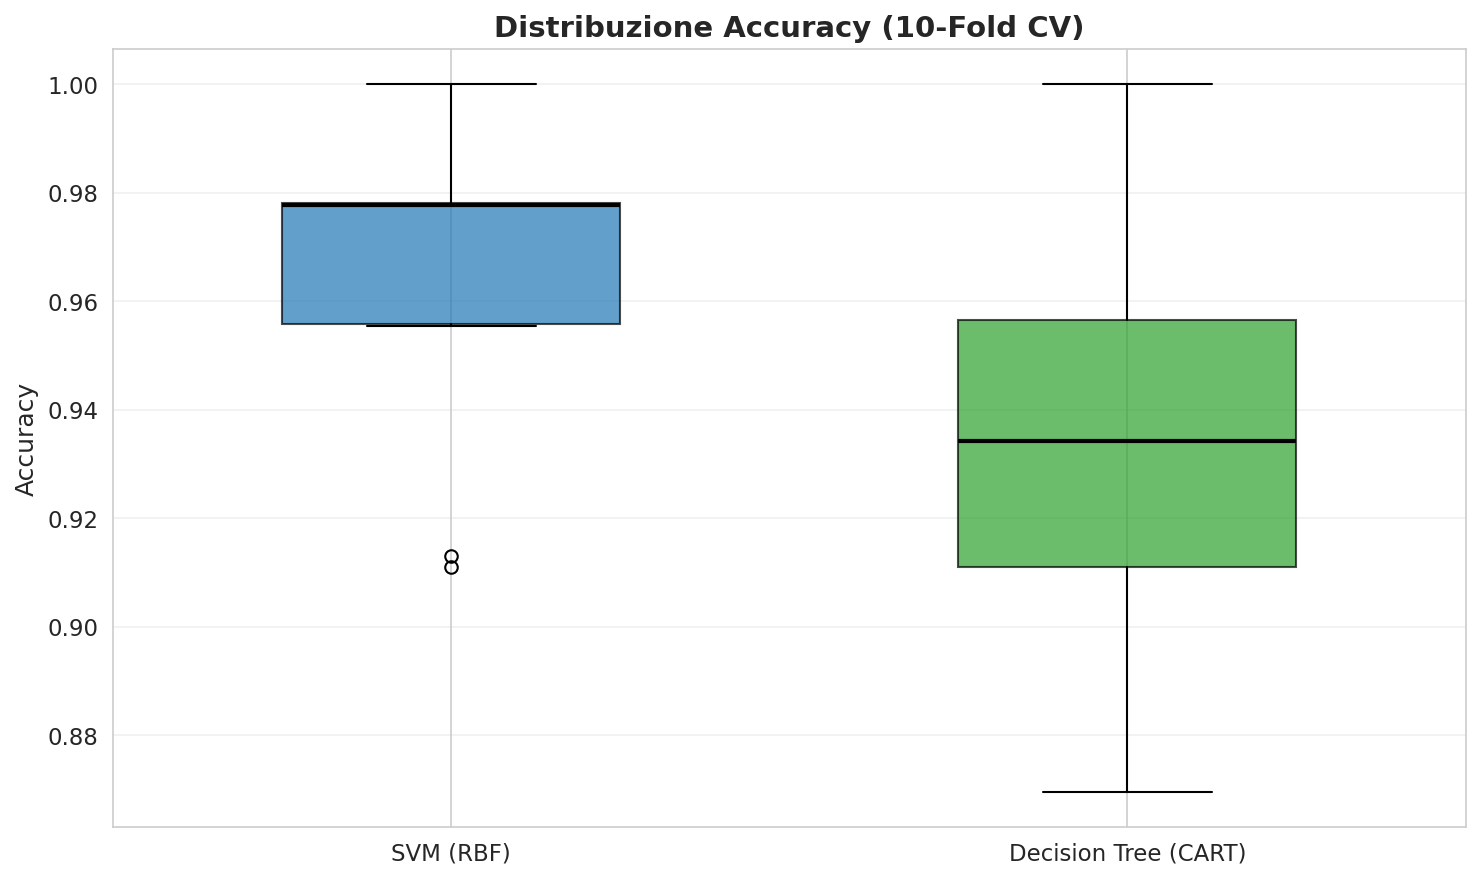

In [19]:
# Boxplot CV accuracy
fig, ax = plt.subplots(figsize=(10, 6))
cv_data = [cv_results[name]['test_accuracy'] for name in pipelines]
bp = ax.boxplot(cv_data, labels=list(pipelines.keys()), patch_artist=True, widths=0.5,
                medianprops=dict(color='black', linewidth=2))
for patch, color in zip(bp['boxes'], ['#1f77b4', '#2ca02c']):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
ax.set_ylabel('Accuracy')
ax.set_title('Distribuzione Accuracy (10-Fold CV)', fontweight='bold')
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('07_cv_boxplot.png', dpi=300, bbox_inches='tight')
plt.show()

### 4.2 Hyperparameter Tuning (GridSearchCV)

In [20]:
# Griglie di iperparametri

svm_param_grid = {
    'classifier__C': [0.1, 1, 10, 100],
    'classifier__gamma': ['scale', 'auto', 0.01, 0.001],
    'classifier__kernel': ['rbf'],
}

dt_param_grid = {
    'classifier__max_depth': [3, 5, 7, 10, None],
    'classifier__min_samples_split': [2, 5, 10, 20],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__ccp_alpha': [0.0, 0.001, 0.005, 0.01, 0.02],
    # TODO Nota: non viene fatto il pruning perchè viene trovato che il parametro migliore è non effettuarlo
}

param_grids = {
    'SVM (RBF)': svm_param_grid,
    'Decision Tree (CART)': dt_param_grid,
}

best_models = {}
tuning_results = []

for name, pipe in pipelines.items():
    n_comb = 1
    for vals in param_grids[name].values():
        n_comb *= len(vals)
    print(f'{name}: {n_comb} combinazioni x 10 fold')

    grid = GridSearchCV(
        pipe,
        param_grid=param_grids[name],
        cv=cv,
        scoring='f1',
        n_jobs=-1,
        refit=True
    )
    grid.fit(X_train, y_train)

    best_models[name] = grid.best_estimator_

    print(f'  Migliori parametri: {grid.best_params_}')
    print(f'  Miglior F1 (CV):    {grid.best_score_:.4f}')

    tuning_results.append({
        'Modello': name,
        'Miglior F1 (CV)': f'{grid.best_score_:.4f}',
        'Parametri': str(grid.best_params_)
    })
    print()

display(pd.DataFrame(tuning_results))

SVM (RBF): 16 combinazioni x 10 fold
  Migliori parametri: {'classifier__C': 100, 'classifier__gamma': 0.001, 'classifier__kernel': 'rbf'}
  Miglior F1 (CV):    0.9705

Decision Tree (CART): 600 combinazioni x 10 fold
  Migliori parametri: {'classifier__ccp_alpha': 0.005, 'classifier__criterion': 'gini', 'classifier__max_depth': 7, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5}
  Miglior F1 (CV):    0.9292



,Modello,Miglior F1 (CV),Parametri
0,SVM (RBF),0.9705,"{'classifier__C': 100, 'classifier__gamma': 0...."
1,Decision Tree (CART),0.9292,"{'classifier__ccp_alpha': 0.005, 'classifier__..."


### 4.3 Valutazione sul Test Set

In [21]:
predictions = {}
test_results = []

for name, model in best_models.items():
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    predictions[name] = {'y_pred': y_pred, 'y_prob': y_prob}

    metrics = {
        'Modello': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_prob),
    }
    test_results.append(metrics)

    print(f'{name}:')
    for k, v in metrics.items():
        if k != 'Modello':
            print(f'  {k:<12s}: {v:.4f}')
    print()

results_df = pd.DataFrame(test_results)
display(results_df.round(4))

SVM (RBF):
  Accuracy    : 0.9825
  Precision   : 1.0000
  Recall      : 0.9524
  F1-Score    : 0.9756
  ROC-AUC     : 0.9974

Decision Tree (CART):
  Accuracy    : 0.9035
  Precision   : 0.8974
  Recall      : 0.8333
  F1-Score    : 0.8642
  ROC-AUC     : 0.8601



,Modello,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,SVM (RBF),0.9825,1.0000,0.9524,0.9756,0.9974
1,Decision Tree (CART),0.9035,0.8974,0.8333,0.8642,0.8601


---
## 5. Analisi dei risultati

### 5.1 Matrici di confusione

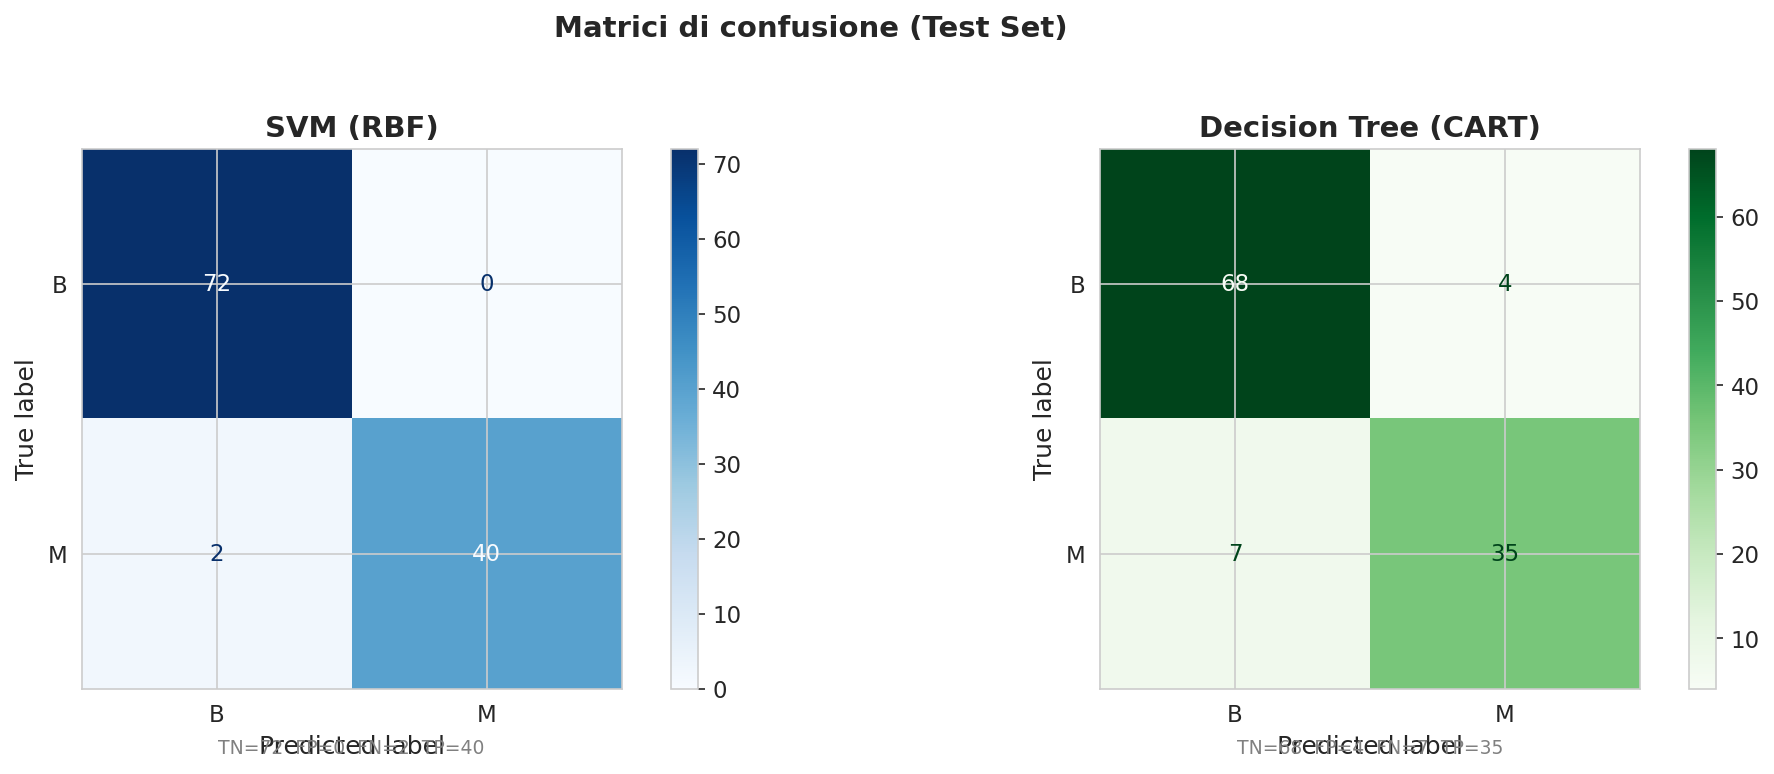

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
cmaps = ['Blues', 'Greens']

for i, (name, preds) in enumerate(predictions.items()):
    ConfusionMatrixDisplay.from_predictions(
        y_test, preds['y_pred'],
        display_labels=le.classes_,
        cmap=cmaps[i],
        ax=axes[i]
    )
    axes[i].set_title(f'{name}', fontweight='bold')

    cm = confusion_matrix(y_test, preds['y_pred'])
    tn, fp, fn, tp = cm.ravel()
    axes[i].text(0.5, -0.12, f'TN={tn}  FP={fp}  FN={fn}  TP={tp}',
                transform=axes[i].transAxes, ha='center', fontsize=9, color='gray')

fig.suptitle('Matrici di confusione (Test Set)', fontweight='bold', fontsize=14, y=1.03)
plt.tight_layout()
plt.savefig('08_confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

In [23]:
for name, preds in predictions.items():
    print(f'{name}')
    print(classification_report(
        y_test, preds['y_pred'],
        target_names=[f'{c} ({i})' for i, c in enumerate(le.classes_)]
    ))

SVM (RBF)
              precision    recall  f1-score   support

       B (0)       0.97      1.00      0.99        72
       M (1)       1.00      0.95      0.98        42

    accuracy                           0.98       114
   macro avg       0.99      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114

Decision Tree (CART)
              precision    recall  f1-score   support

       B (0)       0.91      0.94      0.93        72
       M (1)       0.90      0.83      0.86        42

    accuracy                           0.90       114
   macro avg       0.90      0.89      0.89       114
weighted avg       0.90      0.90      0.90       114



### 7.2 Curve ROC

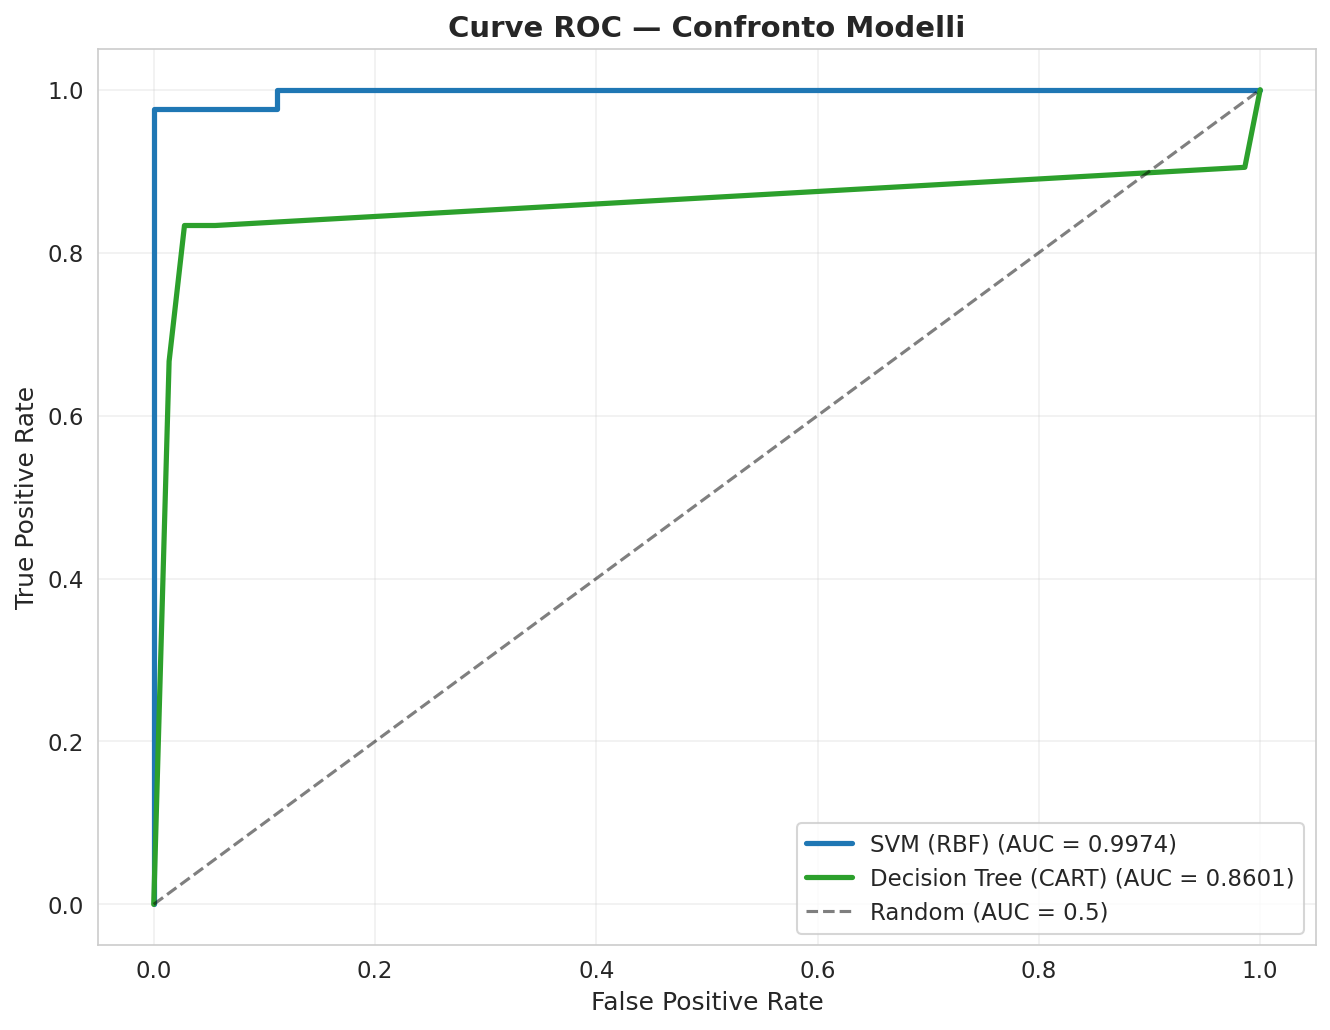

dict_keys(['SVM (RBF)', 'Decision Tree (CART)'])
[0.0191211  0.99178347 0.99178347 0.92147806 0.0191211  0.0191211
 0.92147806 0.83414634 0.0191211  0.0191211 ]
[0.         0.0191211  0.62637363 0.83414634 0.92147806 0.99178347]


In [24]:
fig, ax = plt.subplots(figsize=(9, 7))
colors_roc = ['#1f77b4', '#2ca02c']

for i, (name, preds) in enumerate(predictions.items()):
    fpr, tpr, _ = roc_curve(y_test, preds['y_prob'])
    auc_score = roc_auc_score(y_test, preds['y_prob'])
    ax.plot(fpr, tpr,
            label=f'{name} (AUC = {auc_score:.4f})',
            linewidth=2.5,
            color=colors_roc[i])

ax.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random (AUC = 0.5)')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Curve ROC — Confronto Modelli', fontweight='bold', fontsize=14)
ax.legend(fontsize=11)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('09_roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print(predictions.keys())
print(predictions['Decision Tree (CART)']['y_prob'][:10])
print(np.unique(predictions['Decision Tree (CART)']['y_prob']))


### 7.3 Feature Importance

Pruning: ccp_alpha=0.005, profondita' effettiva=4

Feature Importance — Decision Tree (CART):
(9 feature usate su 30 totali)

   1. perimeter3             0.7624
   2. concave_points3        0.0973
   3. texture3               0.0416
   4. area1                  0.0297
   5. texture1               0.0206
   6. smoothness3            0.0152
   7. concave_points1        0.0120
   8. area2                  0.0110
   9. area3                  0.0101


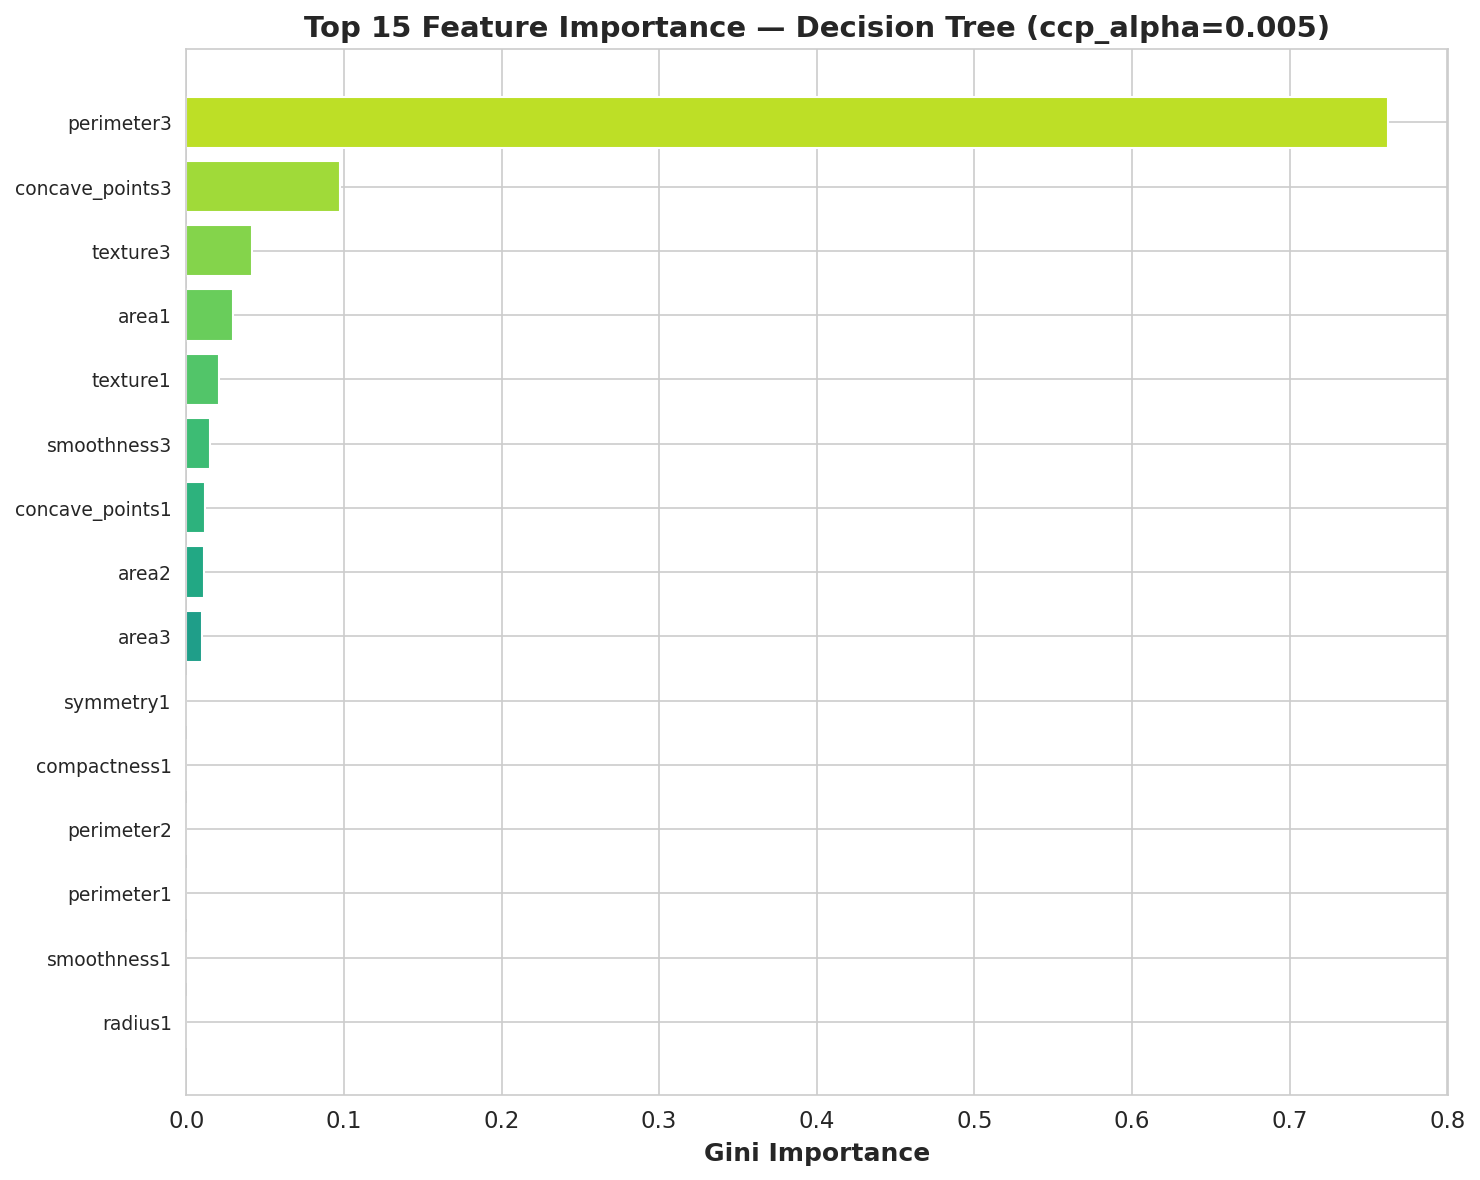

In [25]:
dt_model = best_models['Decision Tree (CART)']
feature_names = list(X.columns)
importances = dt_model.named_steps['classifier'].feature_importances_

fi_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False)

best_ccp = dt_model.named_steps['classifier'].ccp_alpha
best_depth = dt_model.named_steps['classifier'].get_depth()
print(f'Pruning: ccp_alpha={best_ccp}, profondita\' effettiva={best_depth}')
print()

fi_nonzero = fi_df[fi_df['Importance'] > 0]
print(f'Feature Importance — Decision Tree (CART):')
print(f'({len(fi_nonzero)} feature usate su {len(feature_names)} totali)')
print()
for i, (_, row) in enumerate(fi_nonzero.iterrows(), 1):
    print(f'  {i:2d}. {row["Feature"]:<22s} {row["Importance"]:.4f}')

fig, ax = plt.subplots(figsize=(10, 8))
fi_top = fi_df.head(15).sort_values('Importance')
ax.barh(range(len(fi_top)), fi_top['Importance'],
        color=plt.cm.viridis(np.linspace(0.3, 0.9, len(fi_top))))
ax.set_yticks(range(len(fi_top)))
ax.set_yticklabels(fi_top['Feature'], fontsize=9)
ax.set_xlabel('Gini Importance', fontweight='bold')
ax.set_title(f'Top 15 Feature Importance — Decision Tree (ccp_alpha={best_ccp})', fontweight='bold')
plt.tight_layout()
plt.savefig('10_feature_importance_dt.png', dpi=300, bbox_inches='tight')
plt.show()

### 7.4 Visualizzazione Albero Decisionale

Regole dell'albero (prime righe):
|--- perimeter3 <= 112.80
|   |--- concave_points3 <= 0.14
|   |   |--- area1 <= 696.25
|   |   |   |--- class: 0
|   |   |--- area1 >  696.25
|   |   |   |--- class: 1
|   |--- concave_points3 >  0.14
|   |   |--- texture3 <= 25.67
|   |   |   |--- area2 <= 33.40
|   |   |   |   |--- class: 0
|   |   |   |--- area2 >  33.40
|   |   |   |   |--- class: 1
|   |   |--- texture3 >  25.67
|   |   |   |--- class: 1
|--- perimeter3 >  112.80
|   |--- texture1 <= 14.95
|   |   |--- smoothness3 <= 0.14
|   |   |   |--- class: 0
|   |   |--- smoothness3 >  0.14
|   |   |   |--- class: 1
|   |--- texture1 >  14.95
|   |   |--- area3 <= 810.10
|   |   |   |--- concave_points1 <= 0.05
|   |   |   |   |--- class: 0
|   |   |   |--- concave_points1 >  0.05
|   |   |   |   |--- class: 1
|   |   |--- area3 >  810.10
|   |   |   |--- class: 1



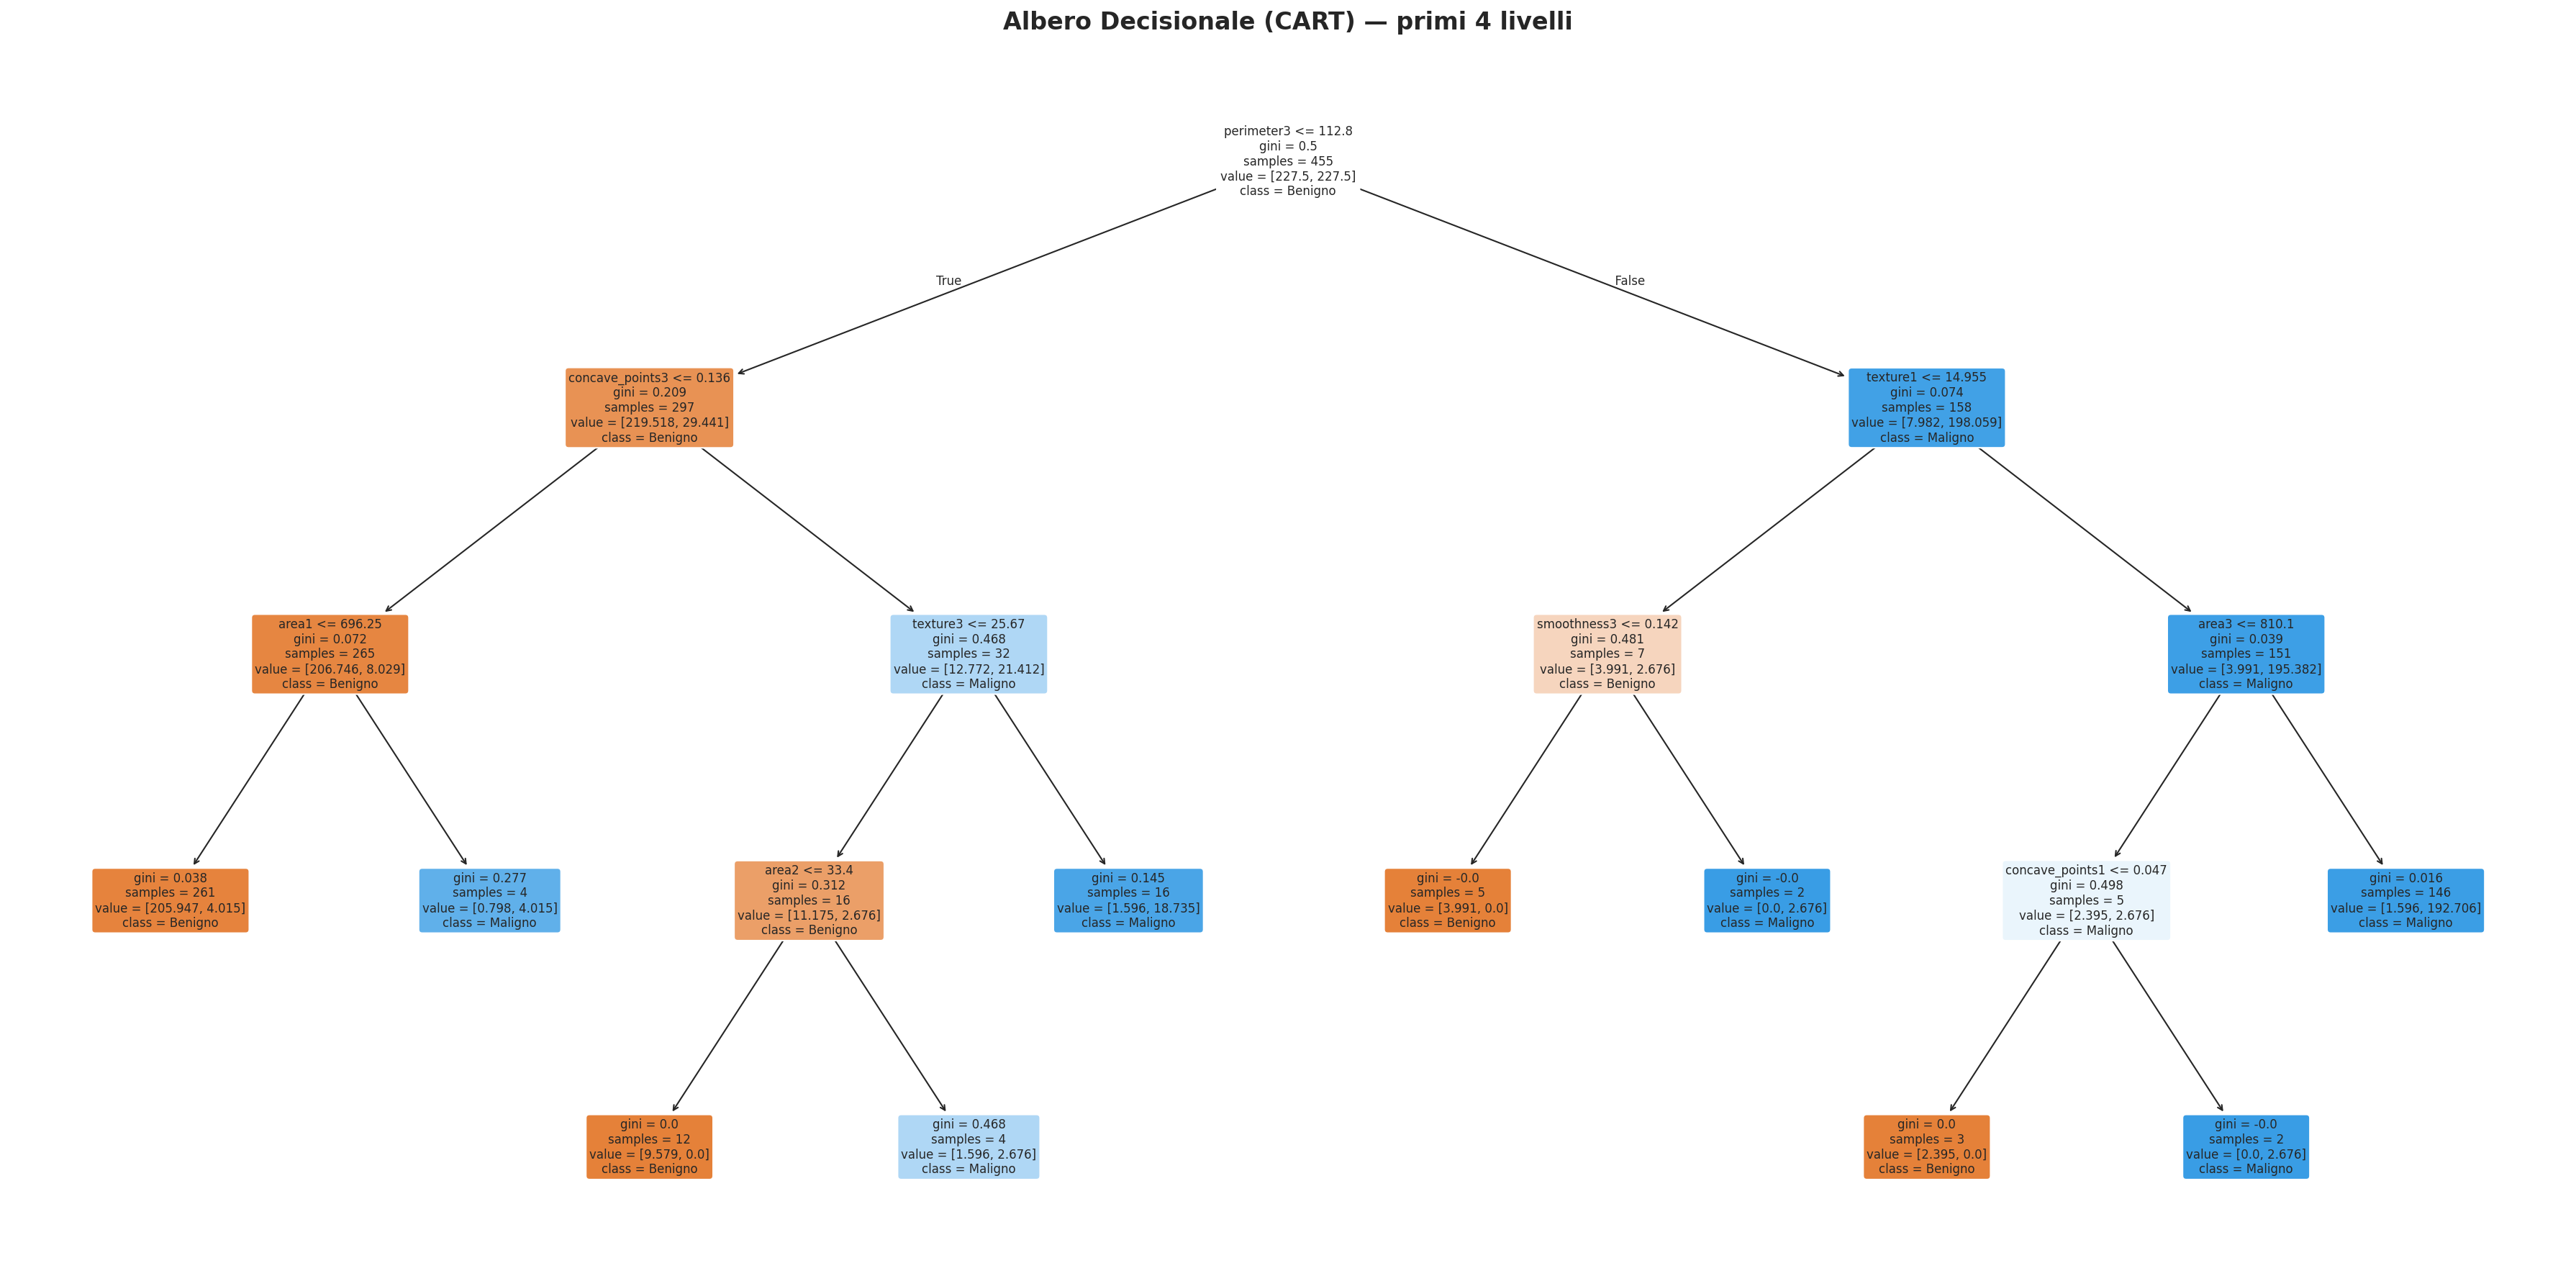

In [26]:
dt_classifier = dt_model.named_steps['classifier']
feat_names = list(X.columns)

print('Regole dell\'albero (prime righe):')
rules = export_text(dt_classifier, feature_names=feat_names, max_depth=3)
print(rules)

fig, ax = plt.subplots(figsize=(24, 12))
plot_tree(
    dt_classifier,
    feature_names=feat_names,
    class_names=['Benigno', 'Maligno'],
    filled=True,
    rounded=True,
    fontsize=8,
    max_depth=4,
    ax=ax
)
ax.set_title('Albero Decisionale (CART) — primi 4 livelli', fontweight='bold', fontsize=16)
plt.tight_layout()
plt.savefig('11_albero_decisionale.png', dpi=200, bbox_inches='tight')
plt.show()

### 7.5 Confronto CV vs Test (Overfitting Check)

In [27]:
# Ri-validazione con i modelli TUNED per un confronto corretto
# (la cross_validate precedente usava iperparametri di default,
#  mentre il test set e' stato valutato con i modelli ottimizzati da GridSearchCV)

# TODO Perchè accuracy e non recall?

cv_results_tuned = {}

for i, name in enumerate(best_models.keys()):
    cv_res_tuned = cross_validate(
        best_models[name], X_train, y_train,
        cv=cv,
        scoring=['accuracy', 'f1'],
        n_jobs=-1
    )
    cv_results_tuned[name] = cv_res_tuned

    cv_acc = cv_res_tuned['test_accuracy'].mean()
    cv_acc_std = cv_res_tuned['test_accuracy'].std()
    cv_f1 = cv_res_tuned['test_f1'].mean()
    cv_f1_std = cv_res_tuned['test_f1'].std()
    test_f1 = results_df.iloc[i]['F1-Score']
    test_acc = results_df.iloc[i]['Accuracy']

    print(f'{name}:')
    print(f'  Accuracy:  CV={cv_acc:.4f} +/- {cv_acc_std:.4f}  Test={test_acc:.4f}  (diff={test_acc-cv_acc:+.4f})')
    print(f'  F1-Score:  CV={cv_f1:.4f} +/- {cv_f1_std:.4f}  Test={test_f1:.4f}  (diff={test_f1-cv_f1:+.4f})')
    print()

SVM (RBF):
  Accuracy:  CV=0.9780 +/- 0.0171  Test=0.9825  (diff=+0.0045)
  F1-Score:  CV=0.9705 +/- 0.0229  Test=0.9756  (diff=+0.0051)

Decision Tree (CART):
  Accuracy:  CV=0.9472 +/- 0.0344  Test=0.9035  (diff=-0.0437)
  F1-Score:  CV=0.9292 +/- 0.0462  Test=0.8642  (diff=-0.0650)



### 7.7 Tabella Riassuntiva Finale

In [28]:
final_summary = []
for i, name in enumerate(pipelines.keys()):
    row = {
        'Modello': name,
        'CV Accuracy (tuned)': f"{cv_results_tuned[name]['test_accuracy'].mean():.4f} +/- {cv_results_tuned[name]['test_accuracy'].std():.4f}",
        'CV F1 (tuned)': f"{cv_results_tuned[name]['test_f1'].mean():.4f} +/- {cv_results_tuned[name]['test_f1'].std():.4f}",
        'Test Accuracy': f"{results_df.iloc[i]['Accuracy']:.4f}",
        'Test Precision': f"{results_df.iloc[i]['Precision']:.4f}",
        'Test Recall': f"{results_df.iloc[i]['Recall']:.4f}",
        'Test F1': f"{results_df.iloc[i]['F1-Score']:.4f}",
        'Test ROC-AUC': f"{results_df.iloc[i]['ROC-AUC']:.4f}",
    }
    final_summary.append(row)

final_df = pd.DataFrame(final_summary)
display(final_df)

final_df.to_csv('risultati_completi.csv', index=False)
print('Risultati salvati in risultati_completi.csv')

,Modello,CV Accuracy (tuned),CV F1 (tuned),Test Accuracy,Test Precision,Test Recall,Test F1,Test ROC-AUC
0,SVM (RBF),0.9780 +/- 0.0171,0.9705 +/- 0.0229,0.9825,1.0000,0.9524,0.9756,0.9974
1,Decision Tree (CART),0.9472 +/- 0.0344,0.9292 +/- 0.0462,0.9035,0.8974,0.8333,0.8642,0.8601


Risultati salvati in risultati_completi.csv
